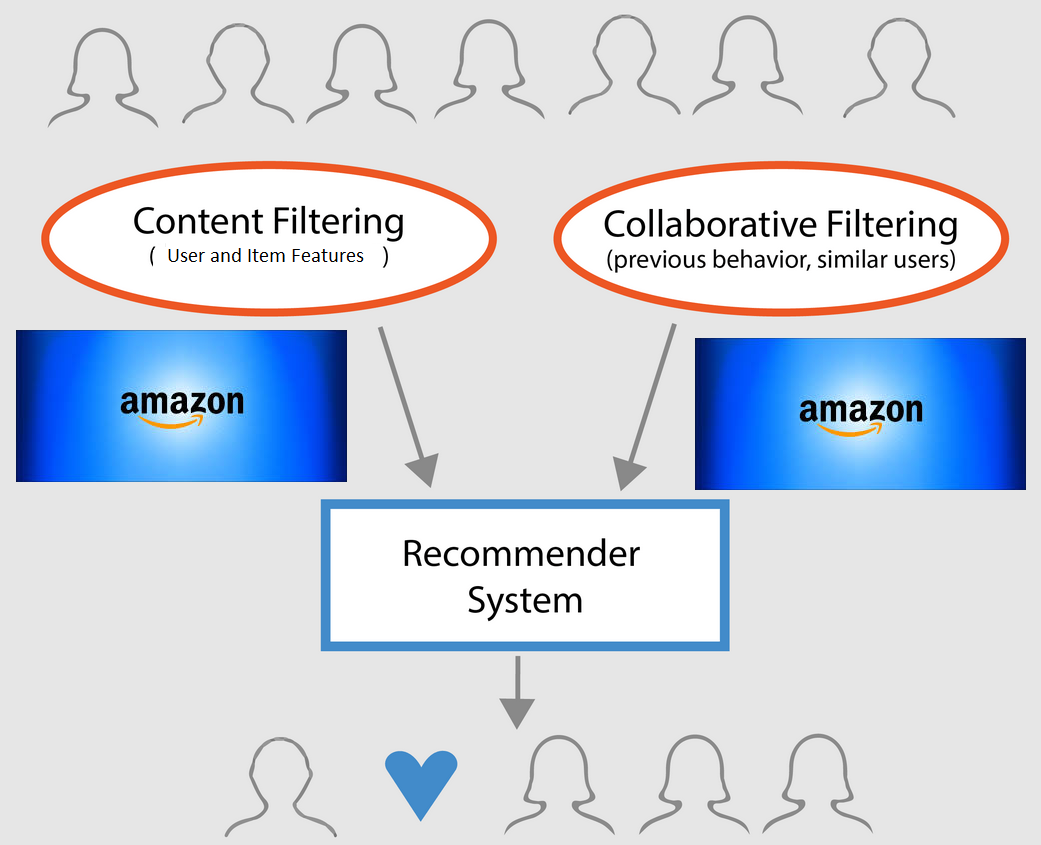

In [1]:
import numpy as np 
import pandas as pd 
from bs4 import BeautifulSoup
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns        
import gc        
import scipy.sparse as sparse
import sys
from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import re
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import KFold

from scipy import stats
from itertools import combinations
import optuna

In [2]:
train = pd.read_csv('/kaggle/input/recommendationsv4/train.csv')
test = pd.read_csv('/kaggle/input/recommendationsv4/test.csv')
scr_prices = pd.read_csv('/kaggle/input/scr-prices/scraped_prices.csv')
uni = pd.read_csv('/kaggle/input/uni-scr/uni_scraped_prices.csv')
meta = pd.read_json('/kaggle/input/recommendationsv4/meta_Grocery_and_Gourmet_Food.json', lines=True)



/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vertical_stack = pd.concat([scr_prices, uni], axis=0)

# Set Up

In [4]:
# This function helps to analyze numerical features

def numerical_columns_anaylysis(table, column, bins):
   
    display(table[column].describe())
    display(table[column].plot(kind='hist', bins=bins))
    # plt.figure(figsize=(8,8))
    fig, axes = plt.subplots(2, figsize=(16, 12))
    sns.distplot(table[column], ax=axes[0])
    sns.boxplot(table[column], ax=axes[1], color='g', meanline=True)
    plt.title(column)
    plt.show()
    
    
    
# category_over_numeric_features function helps to analyze categorical features

def category_over_numeric_features(table, category_feature, stop, numeric_features):
    numeric_clmns = numeric_features
    
    print(table[category_feature].value_counts())
    print('               ')
    print(table[category_feature].value_counts(normalize = 1))
    print('                 ')
    print('Number of unique values  ', table[category_feature].nunique())
    
    lim = table[category_feature].value_counts().index[:stop]

    for clmn in numeric_clmns:
        boarder = 4 * table[clmn].quantile(0.75)
        plt.figure(figsize=(7, 4))
        plt.xticks(rotation=45)
        
        
        boarder = 4 * table[clmn].quantile(0.75)
        plt.ylim(0, boarder)
        
        
        sns.boxplot(x=category_feature, y=clmn,
                    data=table[table[category_feature].isin(lim)], palette='pastel')

        
        



# get_stat_dif checks if statistically significant difference exists between features

def get_stat_dif(column, table, numeric_featurs):
    
    cols = table.loc[:, column].value_counts().index[:15]
    combinations_all = list(combinations(cols, 2))
    for feature in numeric_featurs:

        for comb in combinations_all:
            if stats.ttest_ind(table.loc[table.loc[:, column] == comb[0], feature],
                               table.loc[table.loc[:, column]
                                         == comb[1], feature]
                               ).pvalue <= 0.05 / len(combinations_all):  
                print('Найдены статистически значимые различия для колонки  ',
                      column, '  по  ', feature)
                break

# Data Pre-processing

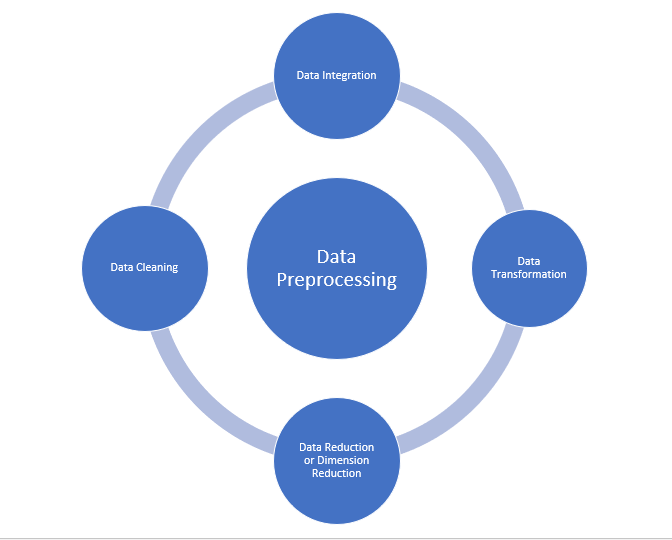

In [5]:
train = train.drop('image', axis=1)
test = test.drop('image', axis=1)

df = train.copy()
df.drop_duplicates(inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828935 entries, 0 to 857894
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         828935 non-null  float64
 1   verified        828935 non-null  bool   
 2   reviewTime      828935 non-null  object 
 3   asin            828935 non-null  object 
 4   reviewerName    828771 non-null  object 
 5   reviewText      828661 non-null  object 
 6   summary         828769 non-null  object 
 7   unixReviewTime  828935 non-null  int64  
 8   vote            115991 non-null  object 
 9   style           429265 non-null  object 
 10  userid          828935 non-null  int64  
 11  itemid          828935 non-null  int64  
 12  rating          828935 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(7)
memory usage: 83.0+ MB


In [6]:
# Before uniting train and test data they need to have the same features

df['sample'] = 1
test['sample'] = 0

test['overall'] = 0
test = test.drop('Id', axis=1)
test['rating'] = 0

test['reviewText'] = ''
test['summary'] = ''


test = test[['overall', 'verified', 'reviewTime', 'asin', 'reviewerName',
       'reviewText', 'summary', 'unixReviewTime', 'vote', 'style',
       'userid', 'itemid', 'rating', 'sample']]


# adding train and test data
data = df.append(test, sort=False).reset_index(drop=True)


# I will drop 'reviewerName' feature, because data have 'userid' feature.
data = data.drop(['reviewerName','reviewText', 'style'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114900 entries, 0 to 1114899
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   overall         1114900 non-null  float64
 1   verified        1114900 non-null  bool   
 2   reviewTime      1114900 non-null  object 
 3   asin            1114900 non-null  object 
 4   summary         1114734 non-null  object 
 5   unixReviewTime  1114900 non-null  int64  
 6   vote            155453 non-null   object 
 7   userid          1114900 non-null  int64  
 8   itemid          1114900 non-null  int64  
 9   rating          1114900 non-null  float64
 10  sample          1114900 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(4)
memory usage: 86.1+ MB


In [7]:
meta = meta.drop(['image', 'description', 'date', 'feature',
                 'similar_item', 'tech1', 'fit'], axis=1)

meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287209 entries, 0 to 287208
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   category   287209 non-null  object
 1   title      287205 non-null  object
 2   brand      275787 non-null  object
 3   rank       275494 non-null  object
 4   also_view  121012 non-null  object
 5   main_cat   285716 non-null  object
 6   price      132136 non-null  object
 7   asin       287209 non-null  object
 8   also_buy   83332 non-null   object
 9   details    273323 non-null  object
dtypes: object(10)
memory usage: 21.9+ MB


In [8]:
# The metadata has much more unique products than train and test data together have.

meta = meta[meta.asin.isin(data.asin)]

meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42003 entries, 10 to 287206
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   42003 non-null  object
 1   title      42003 non-null  object
 2   brand      41574 non-null  object
 3   rank       39547 non-null  object
 4   also_view  22942 non-null  object
 5   main_cat   41920 non-null  object
 6   price      25786 non-null  object
 7   asin       42003 non-null  object
 8   also_buy   29983 non-null  object
 9   details    41175 non-null  object
dtypes: object(10)
memory usage: 3.5+ MB


In [9]:
meta_info = meta[['asin', 'title']]
meta_info.to_csv('title', sep=';', index = None)

In [10]:
# Fist step  to convert 'price' numerical type

meta['price'] = meta.price.apply(lambda x: float(
    re.sub('[$,]', '', x)) if type(x) == str and '-' not in x else x)

In [11]:
meta['tpe'] = meta.price.apply(lambda x: type(x))
meta[meta['tpe'] == str] = meta[meta['tpe'] == str].assign(price = np.nan)
meta['price'] = meta.price.apply(lambda x: float(
    re.sub('[$,]', '', x)) if type(x) == str and '-' not in x else x)

meta = meta.drop('tpe', axis=1)

In [12]:
# Metadata details column contains information: numbers of stars for specific product,
# number of feedbacks, weight of the product. I will build 3 features from this data,
# may be it will help me later.


meta.drop_duplicates(subset=['asin'], inplace=True)


def collect_star_rating(row):
    if pd.notna(row):
        soup = BeautifulSoup(row, 'html.parser')
        try:
            value = soup.find('span', class_="a-icon-alt").text
            return float(value[:3])
        except:
            return np.nan

    return np.nan


meta['num_of_stars'] = meta.details.apply(collect_star_rating)

meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41320 entries, 10 to 287206
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   category      41320 non-null  object 
 1   title         41320 non-null  object 
 2   brand         40895 non-null  object 
 3   rank          38879 non-null  object 
 4   also_view     22309 non-null  object 
 5   main_cat      41237 non-null  object 
 6   price         25218 non-null  float64
 7   asin          41320 non-null  object 
 8   also_buy      29448 non-null  object 
 9   details       40524 non-null  object 
 10  num_of_stars  40201 non-null  float64
dtypes: float64(2), object(9)
memory usage: 3.8+ MB


In [13]:
def num_of_reviews(row):
    if pd.notna(row):
        soup = BeautifulSoup(row, 'html.parser')
        try:
            val = soup.find_all('a', class_='a-link-normal')
            val = val[1].text

            return float(val.split()[0])

        except:
            return np.nan

    return np.nan


meta['num_reviews'] = meta['details'].apply(num_of_reviews)


In [14]:
def product_weight(row):
    if pd.notna(row):

        soup = BeautifulSoup(row, 'html.parser')
        try:
            weight = soup.find('div', class_='content').li.text.split()[2]
            
            return float(weight)
        except:
            return np.nan

    return np.nan


meta['weight'] = meta.details.apply(product_weight)

In [15]:
meta.index = meta.asin

vertical_stack.columns = ['asins', 'prices']



vertical_stack['prices'] = vertical_stack.prices.apply(
    lambda x: float(re.sub('[.,]', '', x)))

meta = pd.merge(left=meta, right=vertical_stack,
                how='left', left_index=True, right_on='asins')


def add_prices(raw):
    if pd.notna(raw['price']) == True:
        return raw['price']

    return raw['prices']


meta['price'] = meta[['price', 'prices']].apply(add_prices, axis=1)

In [16]:
meta['category_string'] = meta.category.apply(lambda x: str(x))
meta['category_depth'] = meta.category.apply(lambda x: len(x))


In [17]:
# The code below adds features from meta to data dataframe

meta.index = meta.asin
data = pd.merge(left=data, right=meta[['category', 'brand', 'rank',
                                       'main_cat', 'price']], how='left', left_on='asin', right_index=True)

data = pd.merge(left=data, right=meta[['num_of_stars', 'num_reviews',
                                       'also_buy', 'weight']], how='left', left_on='asin', right_index=True)

In [18]:
# num_set = set([5,9,0,12,14,19,70,43])
# num_list = [9,10,11,900,43,44,500,70]
# len(num_set.intersection(num_list))

In [19]:
data["category_string"] = data.category.apply(lambda x: str(x))
data["category_depth"] = data.category.apply(lambda x: len(x))




**I will fill in missed data in this part**

In [20]:


table1 = data.groupby("category_string").price.mean()
table2 = data.groupby(["category_string", "brand"]).price.mean()

long_cat = table1.index

table1_dataframe = pd.DataFrame(data=long_cat)

table1_dataframe['new_category_string'] = table1_dataframe.category_string.apply(
    lambda x: re.sub("[\[\]'']", "", x))

table1_dataframe['cat_list'] = table1_dataframe['new_category_string'].str.split(
    ',')
table1_dataframe.reset_index(drop=True)
table1_dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1107 entries, 0 to 1106
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category_string      1107 non-null   object
 1   new_category_string  1107 non-null   object
 2   cat_list             1107 non-null   object
dtypes: object(3)
memory usage: 26.1+ KB


In [21]:
def build_category_vectors(raw):

    length = len(raw['cat_list'])

    if length < 6 and length > 0:

        last_val = raw['cat_list'][-1]
        diff = 6 - length
        val = 0
        for i in range(diff):
            raw['cat_list'].append(last_val + str(i))
            
            val += 1
    if length > 6:

        for i in range(5, length):
            raw['cat_list'][5] += raw['cat_list'][i]
           

    return raw['cat_list'][1], raw['cat_list'][2], raw['cat_list'][3], raw['cat_list'][4], raw['cat_list'][5]


table1_dataframe[['cat1', 'cat2', 'cat3', 'cat4', 'cat5']] = table1_dataframe[[
    'cat_list']].apply(build_category_vectors, axis=1, result_type='expand')

In [22]:
table1_dataframe.index = table1_dataframe.category_string

data = pd.merge(left=data, right=table1_dataframe[[
                'cat1', 'cat2', 'cat3', 'cat4', 'cat5']], how='left', left_on='category_string', right_index=True)

In [23]:
brand_table = data.groupby('cat2').brand.agg(
    lambda x: x.value_counts().index[0])


def fill_in_brands(row):
    if pd.notna(row['brand']):
        return row['brand']

    cat = row['cat2']

    return brand_table[cat]


data['brand'] = data[['brand', 'cat2']].apply(fill_in_brands, axis=1)

In [24]:
table3 = data.groupby("brand").price.mean()
table4 = data.groupby("cat1").price.mean()

def fill_in_prices(raw):
    if pd.notna(raw['price']):
        return raw['price']
    cat = raw["category_string"]
    brand = raw['brand']
    cat1 = raw['cat1']
    try:
        result = table2[cat][brand]
        if pd.notna(result):
            return result
        else:
            result = table1[cat]
            if pd.notna(result):
                return result
            else:
                return table4[cat1]

    except:
        return table4[cat1]


data['price'] = data[["category_string", "brand",
                      "price", "cat1"]].apply(fill_in_prices, axis=1)

In [25]:
# The code below changes data type for 'reviewTime' to get information for the year
# and month of the purchase.

from datetime import datetime

data['r_time_stamp'] = pd.to_datetime(data['reviewTime'], infer_datetime_format=True)
data['r_time_stamp']

data['purchase_year'] = 2019 - data['r_time_stamp'].dt.year
data['purchase_month'] = data['r_time_stamp'].dt.month

In [26]:


def get_rank_value(rank_st):
    if pd.isnull(rank_st['rank']):
        return rank_st['rank']
    if type(rank_st['rank']) == list:
        sub_list = rank_st['rank'][0].split(' in ')

    else:
        sub_list = rank_st['rank'].split('in')

    val = float(re.sub('[#,>]', '', sub_list[0]))

    

    return val


data['rank_val'] = data[['rank', 'price']].apply(
    get_rank_value, axis=1, result_type='expand')

In [27]:
cat1_mean = data.groupby('cat1').rank_val.mean()
cat2_mean = data.groupby('cat2').rank_val.mean()  


t2 = data.groupby(['category_string']).rank_val.mean()
t3 = data.groupby(['category_string', 'brand']).rank_val.mean()


def fill_in_rank_val(raw):
    if pd.notna(raw['rank_val']):
        return raw['rank_val']

    #rk = raw['rank_cat']
    cs = raw['category_string']
    brand = raw['brand']
    cat2 = raw['cat2']
    cat1 = raw['cat1']

    try:
        
        if pd.notna(t2[rk][cs]):
            return t2[rk][cs]
        else:
            if pd.notna(t3[cs][brand]):
                return t3[cs][brand]
            else:
                if pd.notna(cat2_mean[cat2]):

                    return cat2_mean[cat2]
                else:
                    return cat1_mean[cat1]

    except:

        return cat1_mean[cat1]


data['rank_val'] = data[['rank_val', 'category_string',
                         'brand', 'cat1', 'cat2']].apply(fill_in_rank_val, axis=1)          

In [28]:
star_table1 = data.groupby(['brand', 'cat2']).num_of_stars.mean()
star_table2 = data.groupby(['cat2']).num_of_stars.mean()
star_table3 = data.groupby('cat1').num_of_stars.mean()

mean = data.num_of_stars.mean()

In [29]:
def set_num_stars(row):
    if pd.notna(row['num_of_stars']):
        return row['num_of_stars']

    brand = row['brand']
    cat2 = row['cat2']

    try:
        result = star_table1[brand][cat2]
        if pd.notna(result):

            return result

        result = star_table2[cat2]
        if pd.notna(result):
            return result

        return mean

    except:
        return mean


data['num_of_stars'] = data[['num_of_stars', 'brand', 'cat2']].apply(
    set_num_stars, axis=1)
        
    
    

In [30]:
review_table1 = data.groupby(['brand', 'cat2']).num_reviews.mean()
review_table2 = data.groupby(['cat2']).num_reviews.mean()
mean = data.num_reviews.mean()

In [31]:
def set_num_reviews(row):
    if pd.notna(row['num_reviews']):
        return row['num_reviews']

    brand = row['brand']
    cat2 = row['cat2']

    try:
        result = review_table1[brand][cat2]
        if pd.notna(result):

            return result

        result = review_table2[cat2]
        if pd.notna(result):
            return result

        return mean

    except:
        return mean


data['num_reviews'] = data[['num_reviews', 'brand', 'cat2']].apply(
    set_num_reviews, axis=1)

In [32]:
weight_table1 = data.groupby('cat5').weight.mean()
weight_table2 = data.groupby('cat1').weight.mean()
def fill_missing_weight(row):
    if pd.notna(row['weight']):
        return row['weight']
    
    else:
        cat5 = row['cat5']
        cat1 = row['cat1']
        result = weight_table1[cat5]
        
        if pd.notna(result):
            return result
        
        else:
            return weight_table2[cat1]
    
    
data['weight'] = data[['weight', 'cat5', 'cat1']].apply(fill_missing_weight, axis=1)

In [33]:
#data.to_csv('df_table1.csv', sep=';', index = None)

In [34]:
#dat = pd.read_csv('/kaggle/input/datatable2/df_table1.csv', sep=';', header=0)
#data = pd.read_csv('/kaggle/input/datatable2/df_table1.csv',  sep=';', error_bad_lines=False)


In [35]:
# data = data[data.num_of_stars.apply(type) != str]#[data['sample'] == 0]
# data = data[data.mean_rating.apply(type) != str]#[data['sample'] == 0]
# data = data[data.purchase_year.apply(type) != str]#[data['sample'] == 0]
# data = data[pd.isnull(data.purchase_year) == False]

# EDA

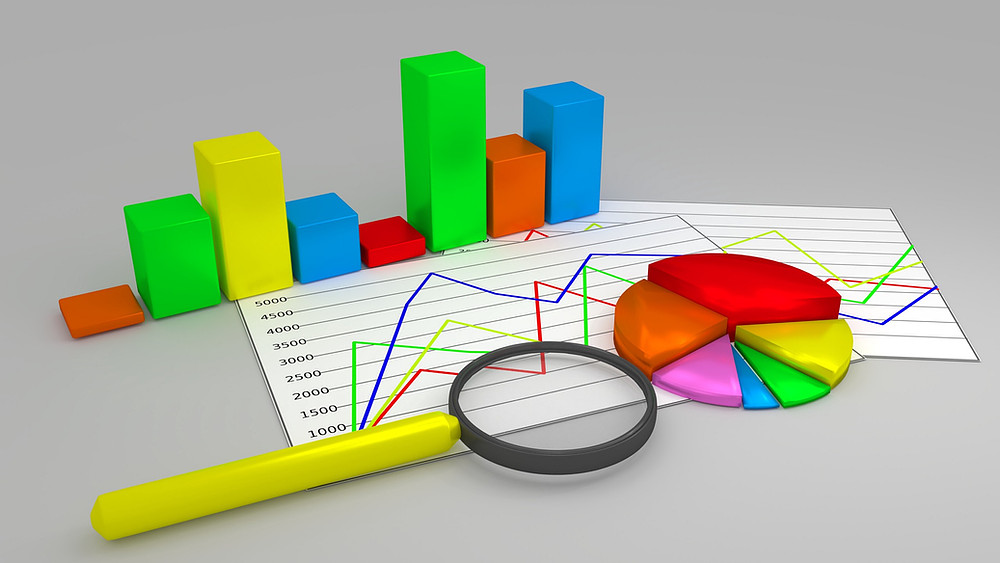

In [36]:
numeric_cols = ['price', 'num_of_stars', 'num_reviews', 'weight', 
                'purchase_year', 'purchase_month', 'rank_val', 'rating']

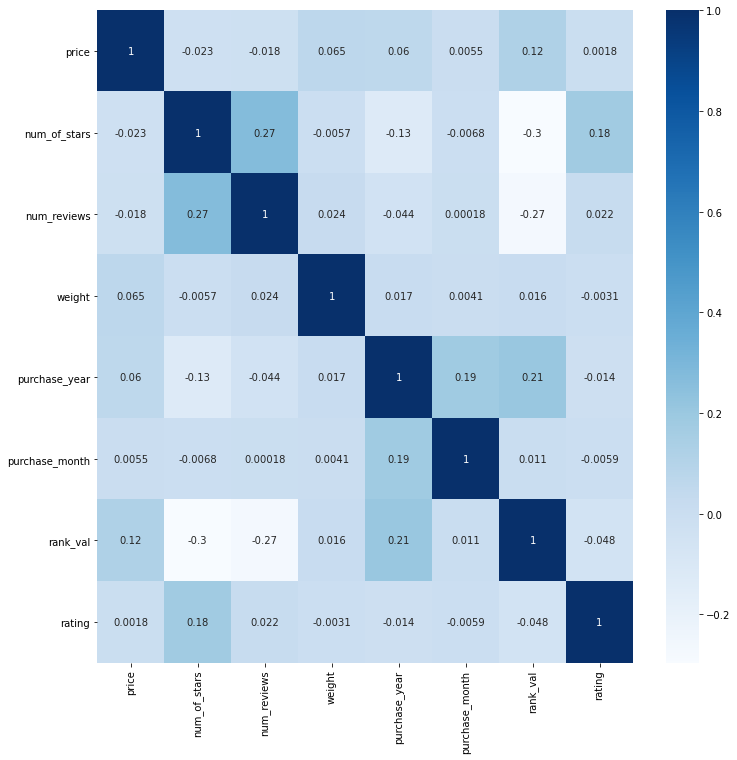

In [37]:
corr_matrix = data[data['sample'] == 1][numeric_cols].corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')

sns.pairplot(data[data['sample'] == 1][numeric_cols])

**The table above shows there is no correlation between numerical features and the target variable.
The highest correlation is between the number of stars and the rank. It really makes sense, because 
Amazon ranks low popular products and search quearies place these products higher on the page. There is a 
slight correlation between the number of stars and the number of reviews.**


In [38]:
# The code below creates dataframe of unique products with some features from data.

sub_chart = data[['asin', 'rank_val', 'num_of_stars', 'num_reviews', 'weight', 'price', 'verified', 'brand', 'cat1']].copy()
sub_chart.drop_duplicates(subset=['asin'], inplace = True)

# Price

count    1.114900e+06
mean     2.163060e+01
std      2.169826e+01
min      1.000000e-02
25%      1.299000e+01
50%      1.853000e+01
75%      2.656672e+01
max      1.811000e+03
Name: price, dtype: float64

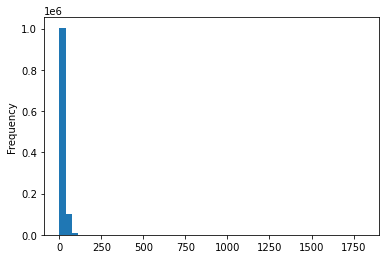

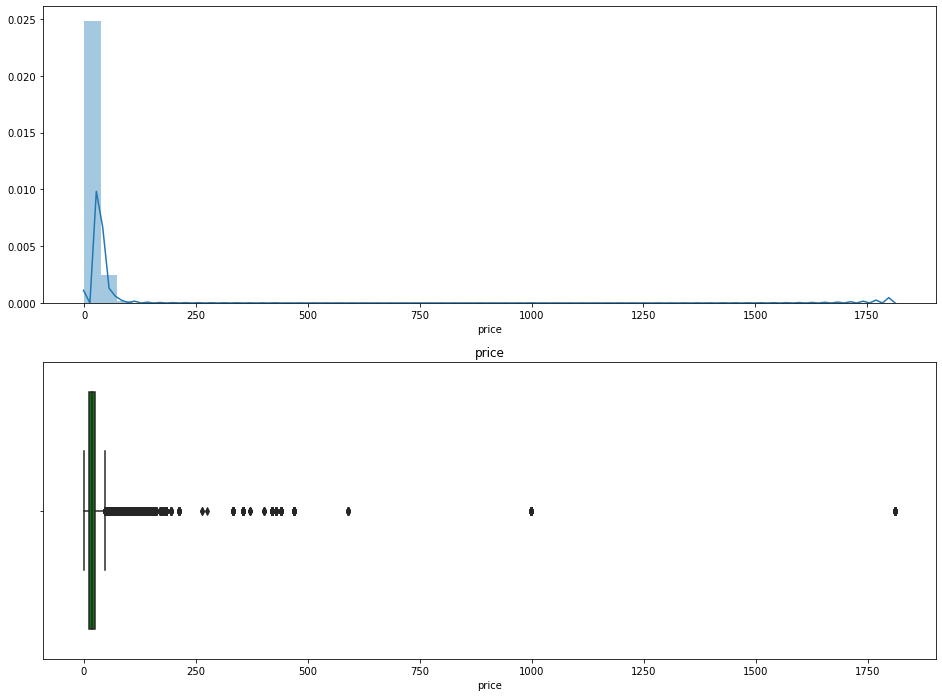

In [39]:
numerical_columns_anaylysis(data, 'price', 50)

count    41320.000000
mean        21.928485
std         27.358146
min          0.010000
25%         12.490000
50%         18.750000
75%         26.490000
max       1811.000000
Name: price, dtype: float64

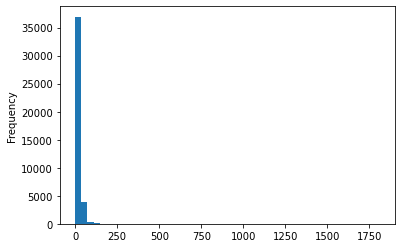

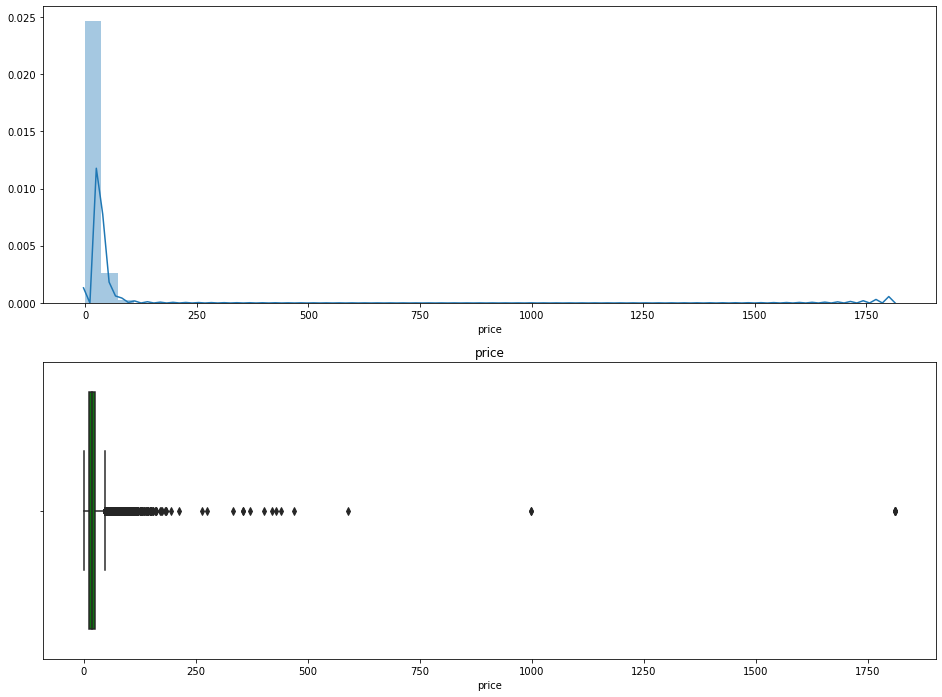

In [40]:
# price distribution for unique products 

numerical_columns_anaylysis(sub_chart, 'price', 50)

In [41]:
# Majority of the products have price in the range from $10 to $20.
# I suspect price doesn't have much influence on rating.



count    1.114900e+06
mean     2.898080e+00
std      5.849063e-01
min     -4.605170e+00
25%      2.564180e+00
50%      2.919391e+00
75%      3.279659e+00
max      7.501634e+00
Name: log_price, dtype: float64

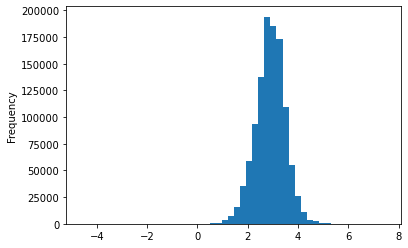

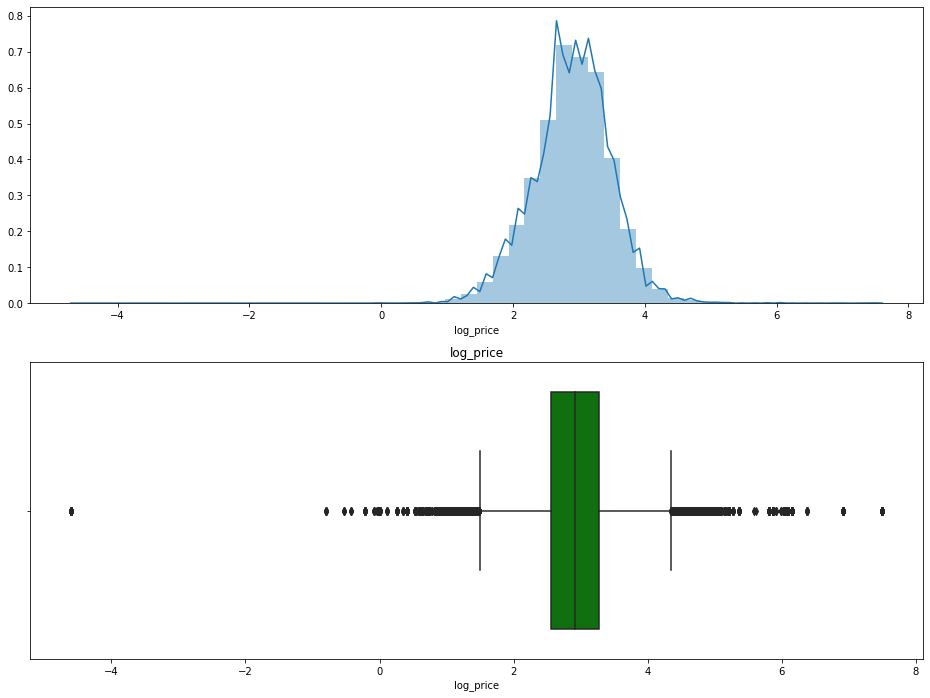

In [42]:
# lets check the distribution of price after using np.log function

data['log_price'] = np.log(data['price'])
numerical_columns_anaylysis(data, 'log_price', 50)

In [43]:
# I will experiment with 'log_price' feature too

# 'num_of_stars'

count    1.114900e+06
mean     4.133660e+00
std      4.330808e-01
min      1.000000e+00
25%      3.900000e+00
50%      4.200000e+00
75%      4.400000e+00
max      5.000000e+00
Name: num_of_stars, dtype: float64

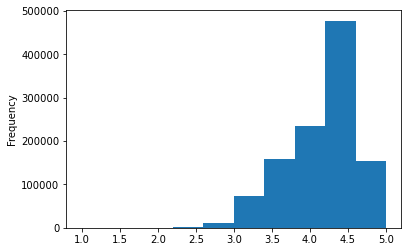

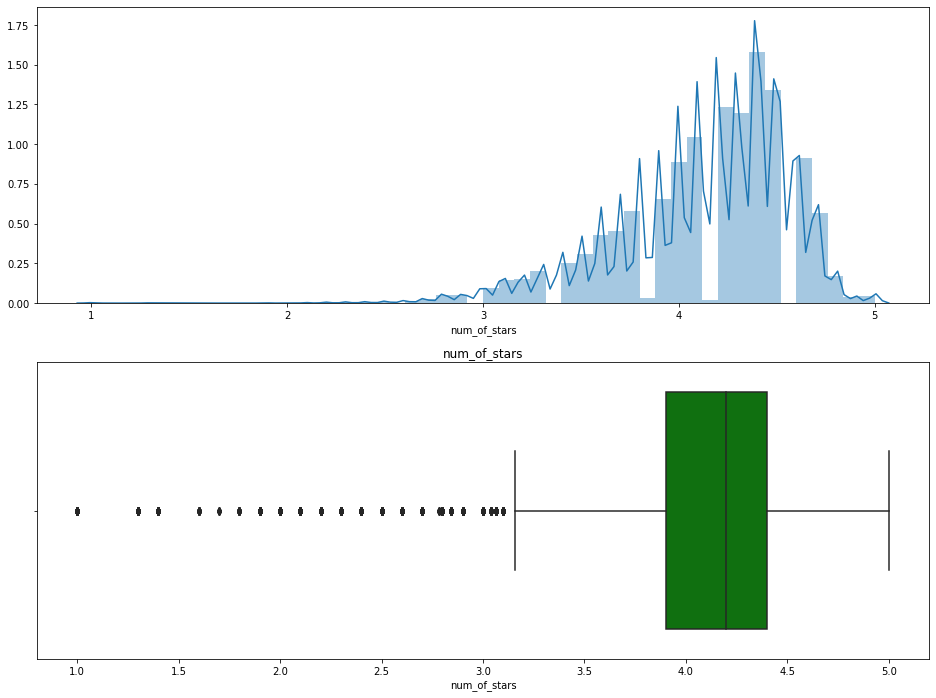

In [44]:
numerical_columns_anaylysis(data, 'num_of_stars', 10)

count    41320.000000
mean         3.974301
std          0.502612
min          1.000000
25%          3.600000
50%          4.000000
75%          4.300000
max          5.000000
Name: num_of_stars, dtype: float64

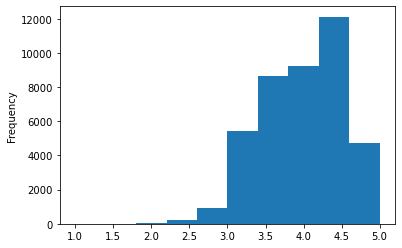

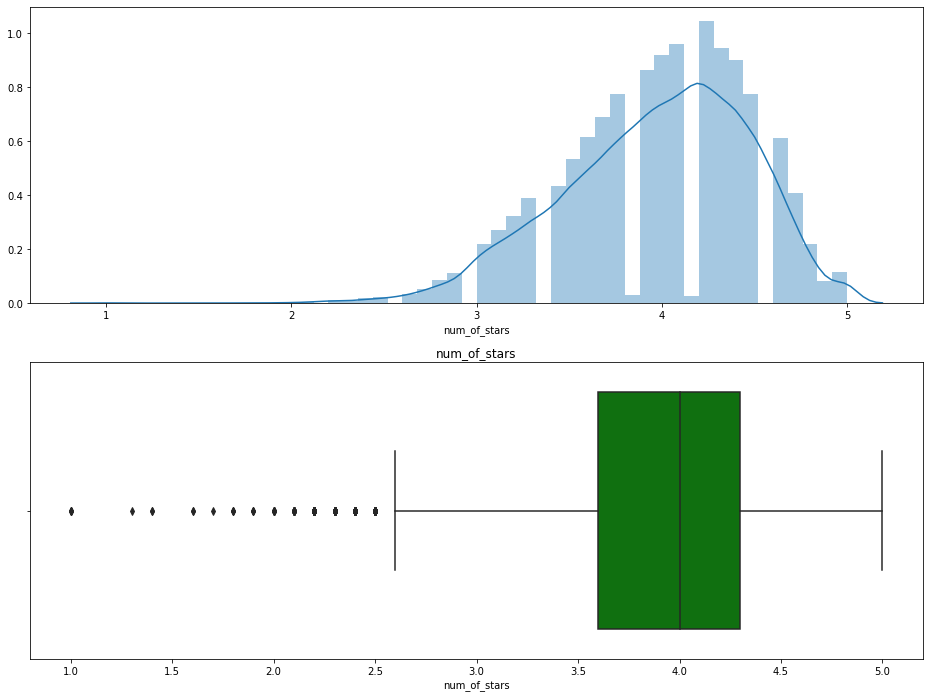

In [45]:
# unique products, number of stars distribution

numerical_columns_anaylysis(sub_chart, 'num_of_stars', 10)

In [46]:
# Many products have 4 stars from data. If stars have some meaning then it means people like
# majority of products. Lets check how distribution of specific number of stars is related to rating.

data['round_stars'] = round(data['num_of_stars'], 1)

data[data['sample'] == 1].groupby('round_stars').rating.value_counts(normalize=1).tail(50)

round_stars  rating
2.6          1.0       0.612319
             0.0       0.387681
2.7          1.0       0.607237
             0.0       0.392763
2.8          1.0       0.632911
             0.0       0.367089
2.9          1.0       0.635155
             0.0       0.364845
3.0          1.0       0.661549
             0.0       0.338451
3.1          1.0       0.704276
             0.0       0.295724
3.2          1.0       0.699575
             0.0       0.300425
3.3          1.0       0.736265
             0.0       0.263735
3.4          1.0       0.742498
             0.0       0.257502
3.5          1.0       0.753458
             0.0       0.246542
3.6          1.0       0.770337
             0.0       0.229663
3.7          1.0       0.793475
             0.0       0.206525
3.8          1.0       0.804714
             0.0       0.195286
3.9          1.0       0.816555
             0.0       0.183445
4.0          1.0       0.822638
             0.0       0.177362
4.1          1.0    

In [47]:
# The ratio of positive to negative ratings increases with number of stars

# 'num_reviews'

count    1.114900e+06
mean     2.281779e+02
std      2.186857e+02
min      1.000000e+00
25%      6.100000e+01
50%      1.560000e+02
75%      3.104310e+02
max      9.990000e+02
Name: num_reviews, dtype: float64

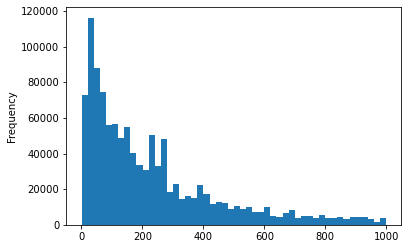

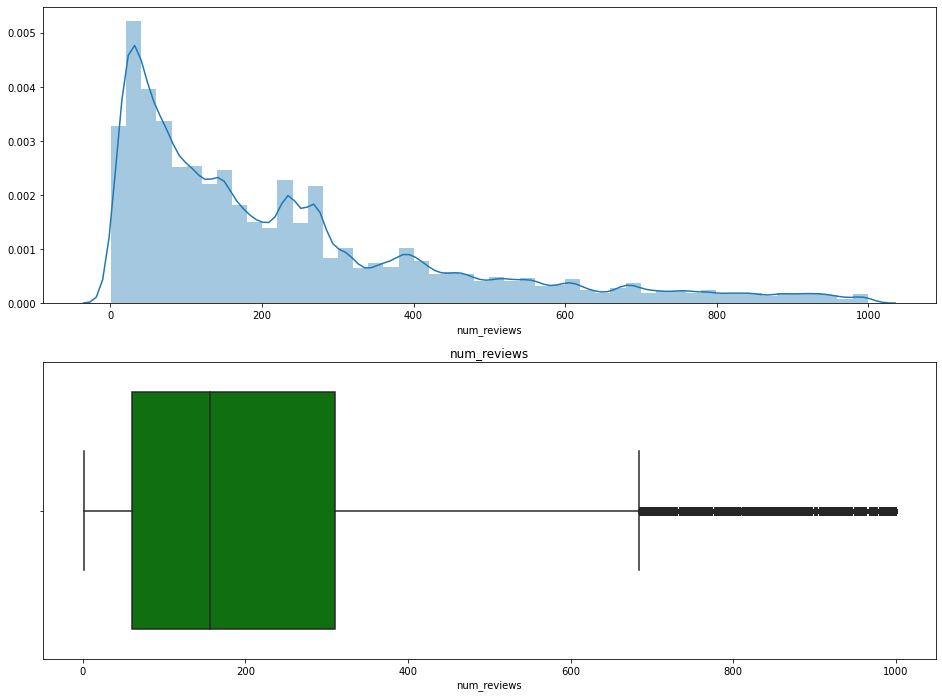

In [48]:

numerical_columns_anaylysis(data, 'num_reviews', 50)

count    41320.000000
mean        88.108007
std        127.109327
min          1.000000
25%         22.000000
50%         42.000000
75%         95.000000
max        999.000000
Name: num_reviews, dtype: float64

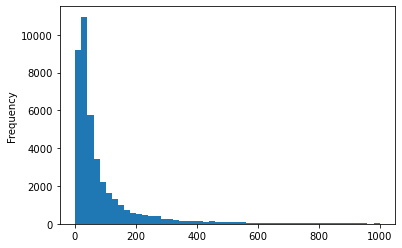

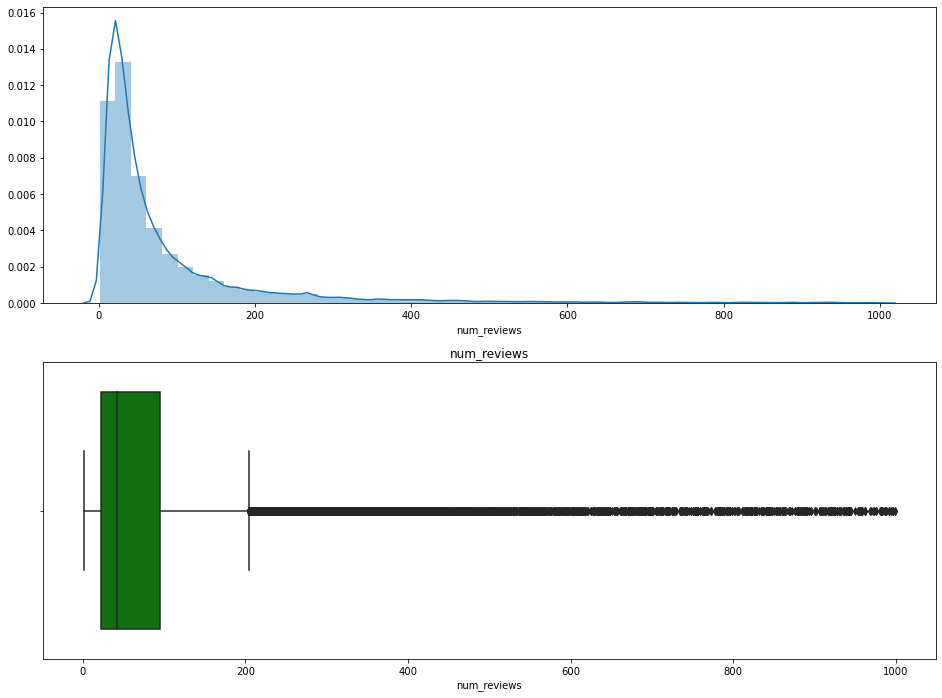

In [49]:

# number of feedbacks distribution for unique products

numerical_columns_anaylysis(sub_chart, 'num_reviews', 50)

count    1.114900e+06
mean     4.901710e+00
std      1.147096e+00
min      0.000000e+00
25%      4.110874e+00
50%      5.049856e+00
75%      5.737962e+00
max      6.906755e+00
Name: log_reviews, dtype: float64

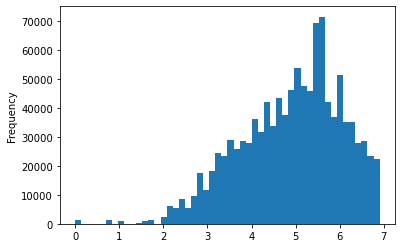

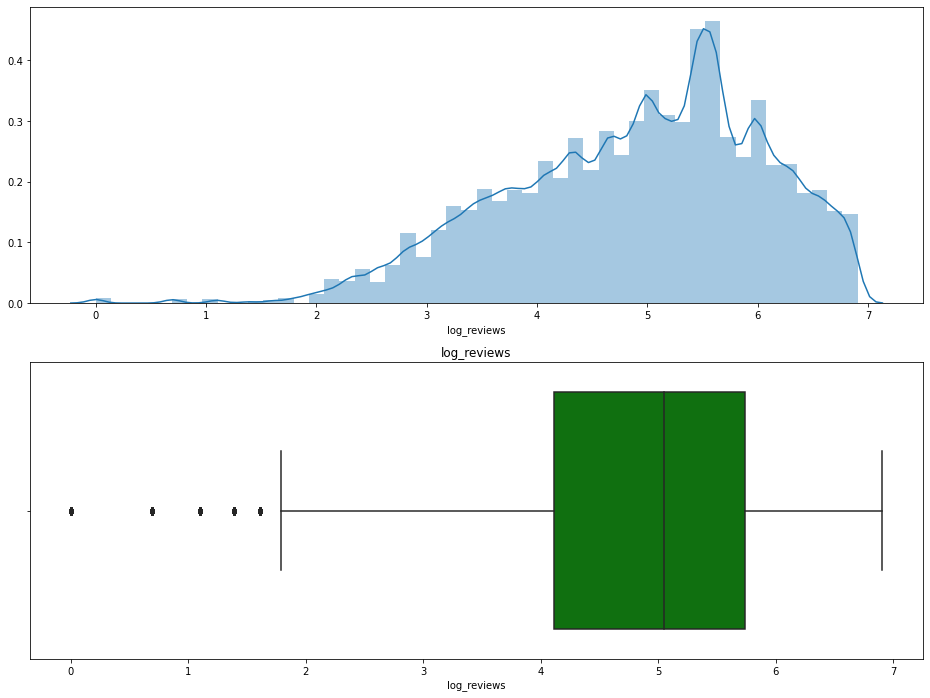

In [50]:


# This distribution shows number of unique products decrease with growing number of feedbacks.
# This data shows some correlation between number of feedbacks and number of specific product purchases.

# Lets check the distribution after logarithm
data['log_reviews'] = np.log(data['num_reviews'])

numerical_columns_anaylysis(data, 'log_reviews', 50)

In [51]:
# The heat map shows small correalation between number of stars and number of feedbacks, but there are
# many people who leave feedbacks when they hugely unsatisfied.

# 'weight'

count    1.114900e+06
mean     6.092682e+00
std      6.636244e+00
min      1.000000e-01
25%      2.400000e+00
50%      5.000000e+00
75%      8.500000e+00
max      4.291000e+02
Name: weight, dtype: float64

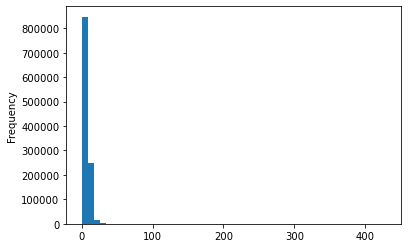

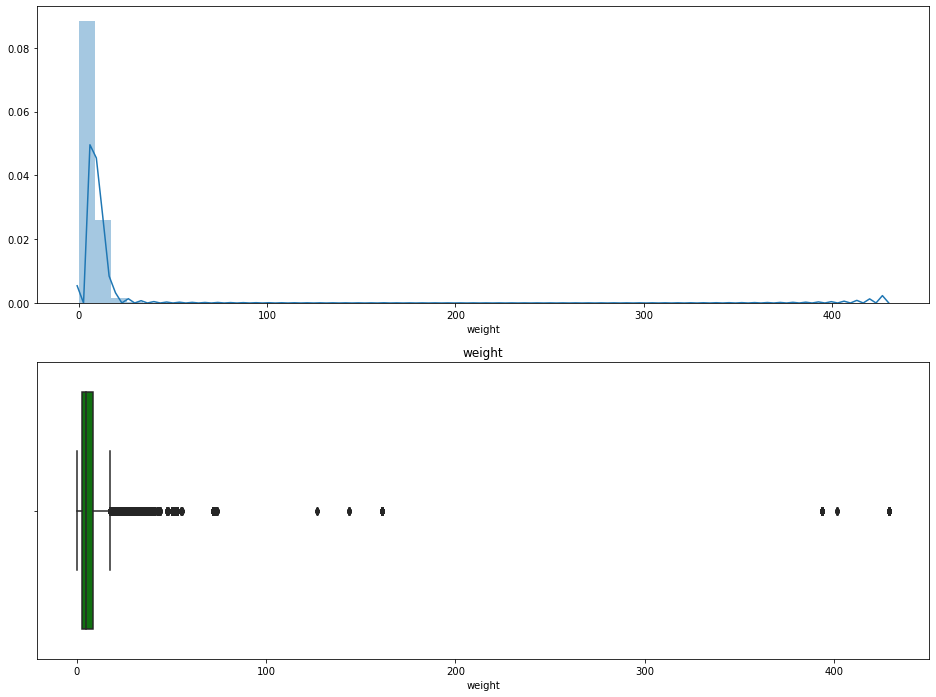

In [52]:
numerical_columns_anaylysis(data, 'weight', 50)

count    41320.000000
mean         5.803803
std          6.188945
min          0.100000
25%          2.200000
50%          4.612268
75%          8.000000
max        429.100000
Name: weight, dtype: float64

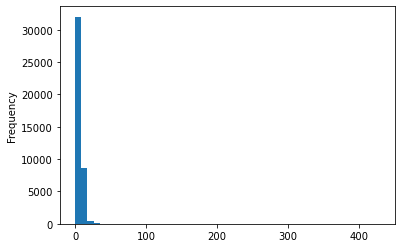

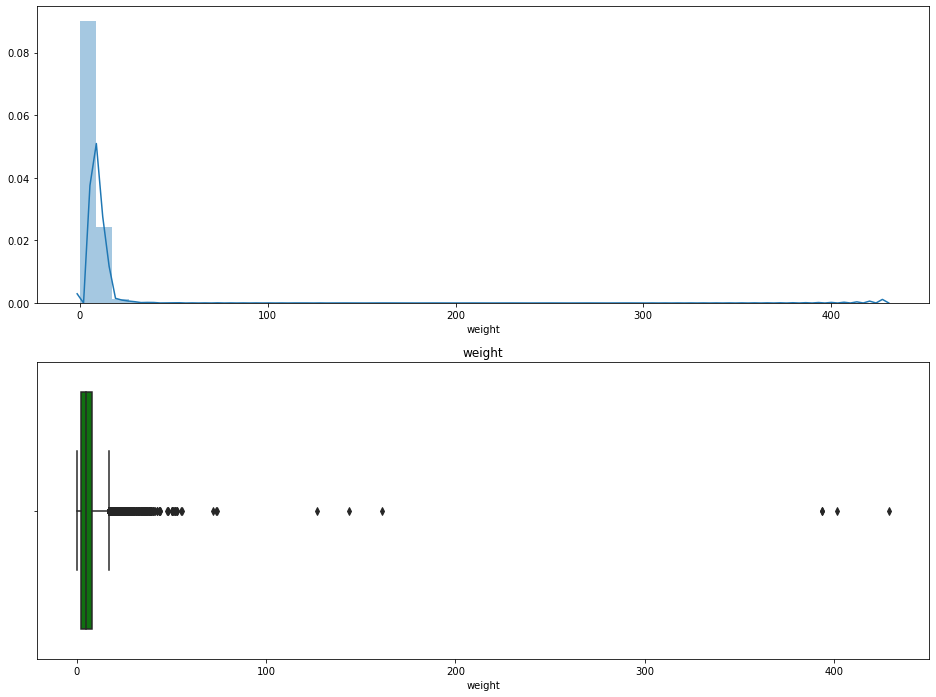

In [53]:
# weight distribution for unique products
numerical_columns_anaylysis(sub_chart, 'weight', 50)

In [54]:
# The majority of products are not heavy and weight doesn't have correlation with other features

# 'rank_val'

count    1.114900e+06
mean     1.057143e+05
std      1.556600e+05
min      4.000000e+00
25%      1.040100e+04
50%      4.703000e+04
75%      1.414090e+05
max      3.573503e+06
Name: rank_val, dtype: float64

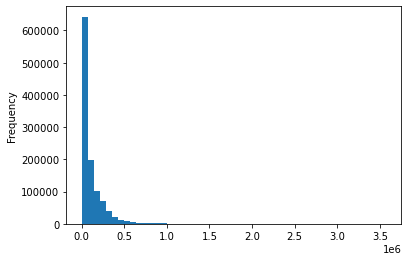

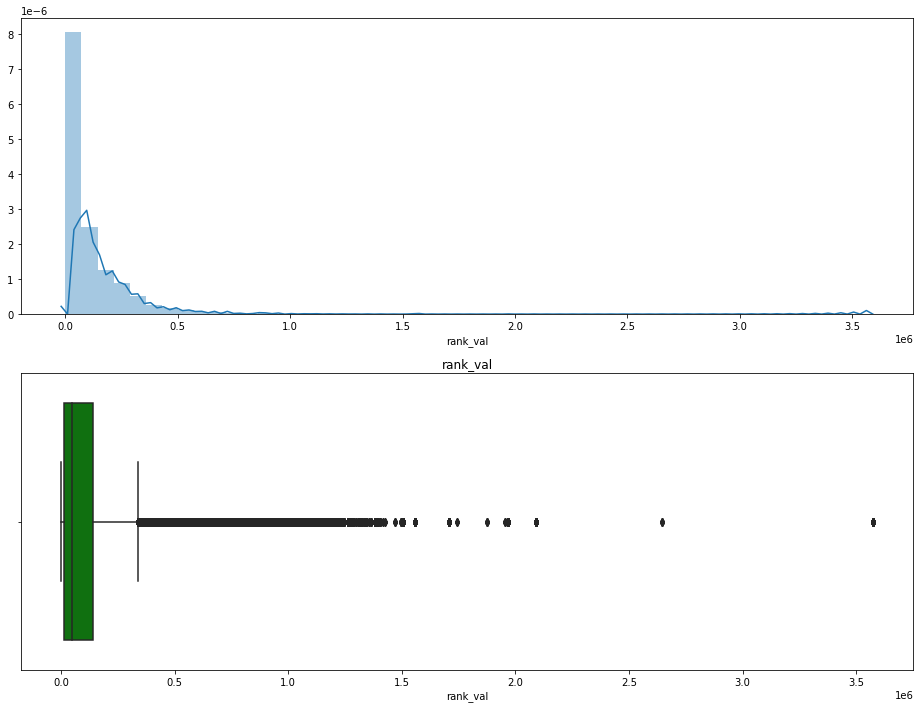

In [55]:

numerical_columns_anaylysis(data, 'rank_val', 50)

count    4.132000e+04
mean     1.651054e+05
std      1.729999e+05
min      4.000000e+00
25%      4.137025e+04
50%      1.132236e+05
75%      2.371072e+05
max      3.573503e+06
Name: rank_val, dtype: float64

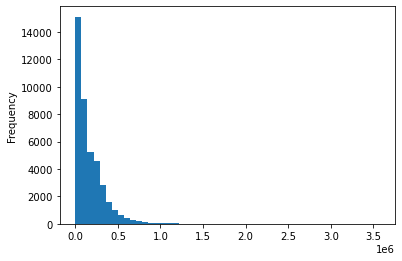

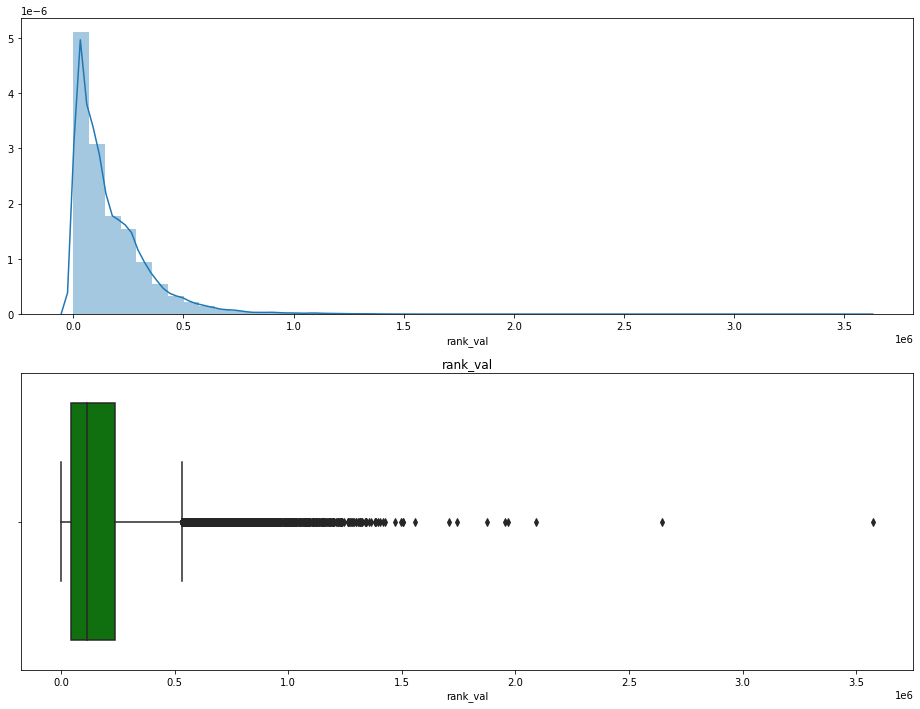

In [56]:
# rank distribution for unique products
numerical_columns_anaylysis(sub_chart, 'rank_val', 50)

In [57]:
# Products with low rank are much more popular in this data as expected.
# People buy them more often.

count    1.114900e+06
mean     1.035372e+01
std      2.059270e+00
min      1.386294e+00
25%      9.249657e+00
50%      1.075854e+01
75%      1.185941e+01
max      1.508906e+01
Name: log_rank_val, dtype: float64

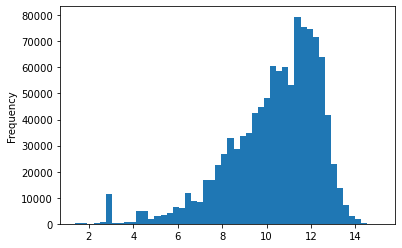

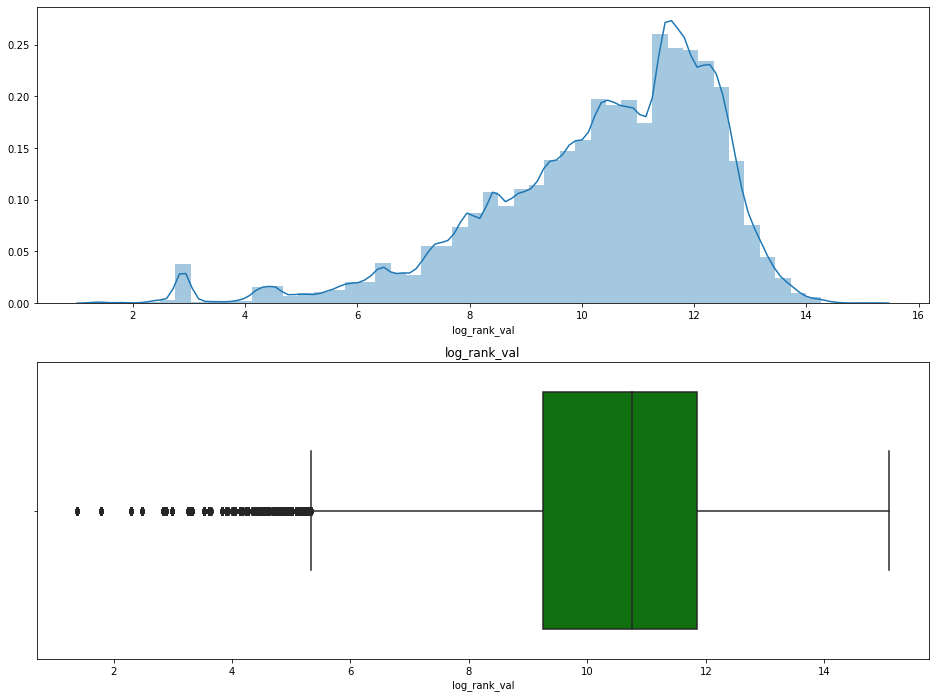

In [58]:
# Lets check it after logarithm
data['log_rank_val'] = np.log(data['rank_val'])
numerical_columns_anaylysis(data, 'log_rank_val', 50)

# 'purchase_year'

count    1.114900e+06
mean     3.781702e+00
std      1.923795e+00
min      1.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      1.900000e+01
Name: purchase_year, dtype: float64

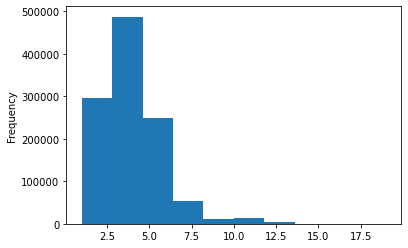

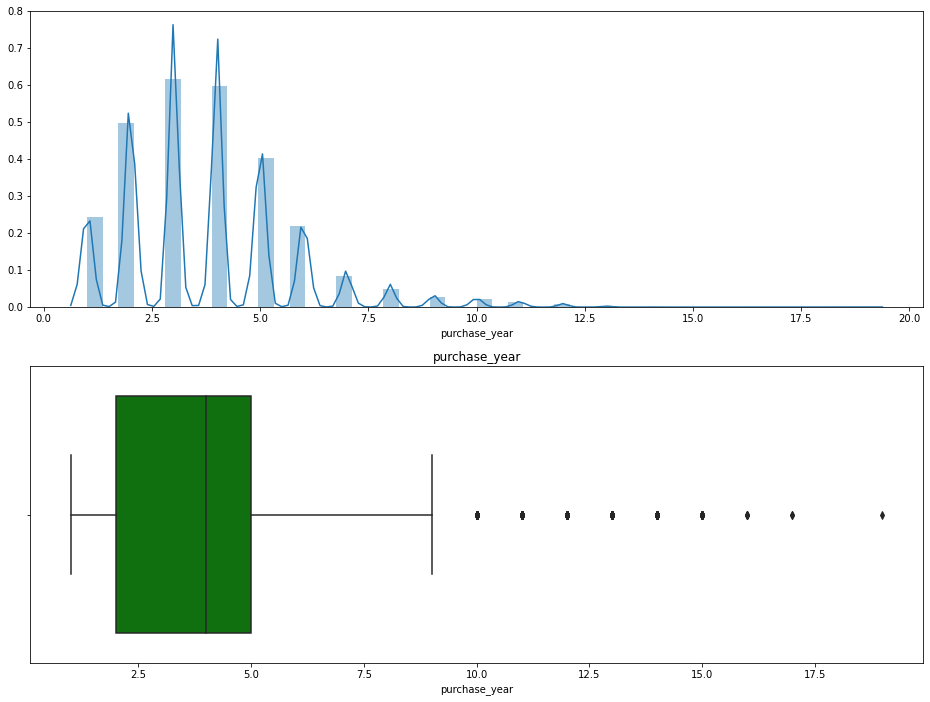

In [59]:
numerical_columns_anaylysis(data, 'purchase_year', 10)

In [60]:
# The distribution of purchases by year shows number of purchases increases with time.
# It's possible to convert this feature to categorical feature and check if it improves model.

# 'purchase_month'

count    1.114900e+06
mean     6.283783e+00
std      3.506378e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      9.000000e+00
max      1.200000e+01
Name: purchase_month, dtype: float64

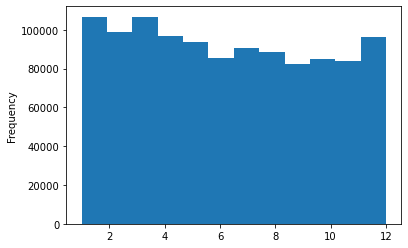

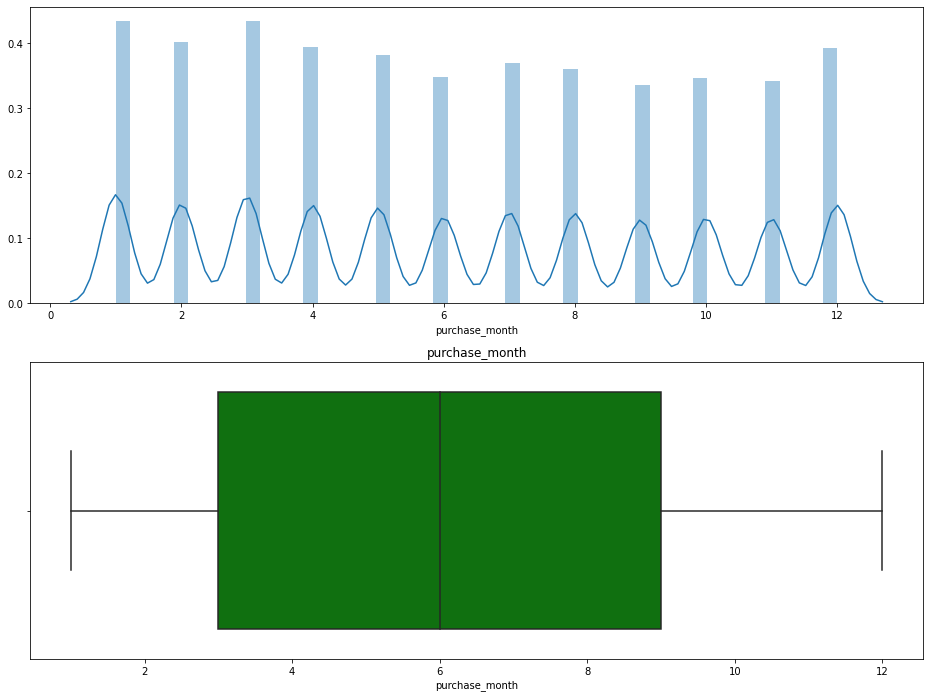

In [61]:
numerical_columns_anaylysis(data, 'purchase_month', 12)

In [62]:
# I don't see much difference after observing graphs.

# Categorical Features

In [63]:
cat_features = ['verified', 'asin', 'userid', 'brand', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'rating']

# 'verified'

True     968433
False    146467
Name: verified, dtype: int64
               
True     0.868628
False    0.131372
Name: verified, dtype: float64
                 
Number of unique values   2


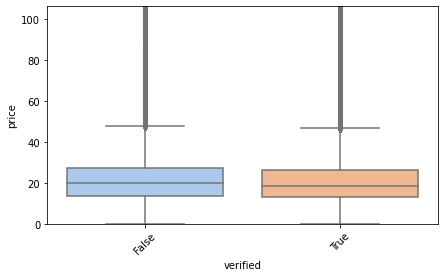

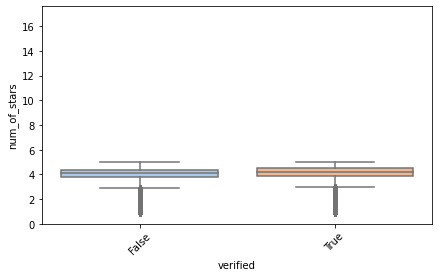

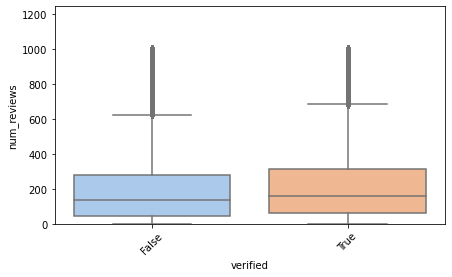

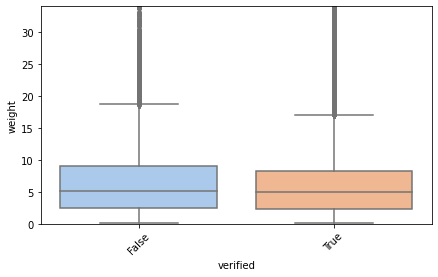

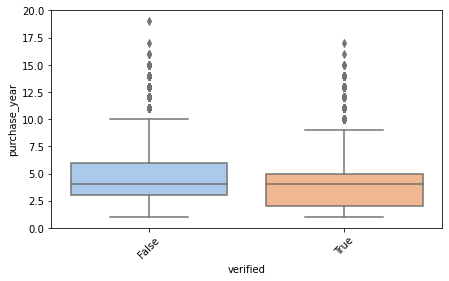

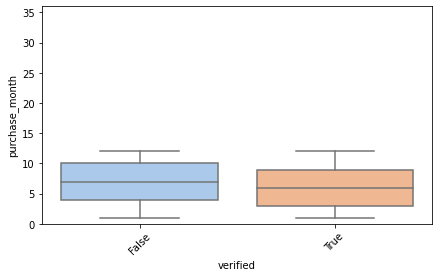

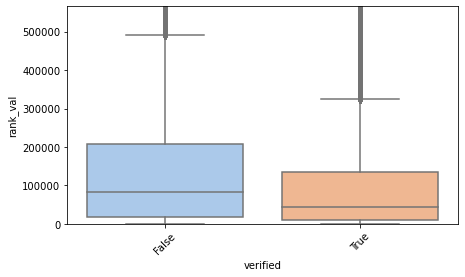

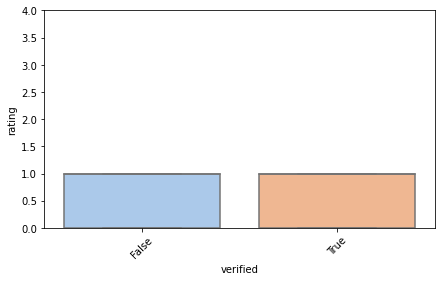

In [64]:

category_over_numeric_features(data, 'verified', 2, numeric_cols)

In [65]:
# Graphs show unverified purchases are more often get products with high ranking.

In [66]:
print(get_stat_dif('verified', data, numeric_cols))

Найдены статистически значимые различия для колонки   verified   по   price
Найдены статистически значимые различия для колонки   verified   по   num_of_stars
Найдены статистически значимые различия для колонки   verified   по   num_reviews
Найдены статистически значимые различия для колонки   verified   по   weight
Найдены статистически значимые различия для колонки   verified   по   purchase_year
Найдены статистически значимые различия для колонки   verified   по   purchase_month
Найдены статистически значимые различия для колонки   verified   по   rank_val
Найдены статистически значимые различия для колонки   verified   по   rating
None


In [67]:
# 'verifed' has statistically significant differences with all numerical features.

# 'asin'

B00BUKL666    7326
B00D3M2QP4    6221
B008QMX2SG    6185
B00R7PWK7W    3289
B0001LO3FG    2922
              ... 
B0012R1OZ0       1
B000YINEYW       1
B0012NJB2M       1
B0017I1QAW       1
B0012QDZBM       1
Name: asin, Length: 41320, dtype: int64
               
B00BUKL666    6.570993e-03
B00D3M2QP4    5.579873e-03
B008QMX2SG    5.547583e-03
B00R7PWK7W    2.950040e-03
B0001LO3FG    2.620863e-03
                  ...     
B0012R1OZ0    8.969414e-07
B000YINEYW    8.969414e-07
B0012NJB2M    8.969414e-07
B0017I1QAW    8.969414e-07
B0012QDZBM    8.969414e-07
Name: asin, Length: 41320, dtype: float64
                 
Number of unique values   41320


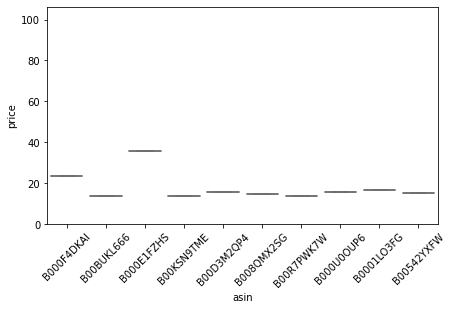

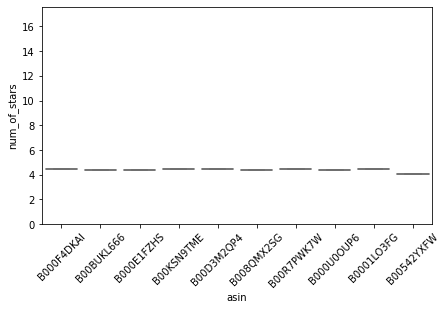

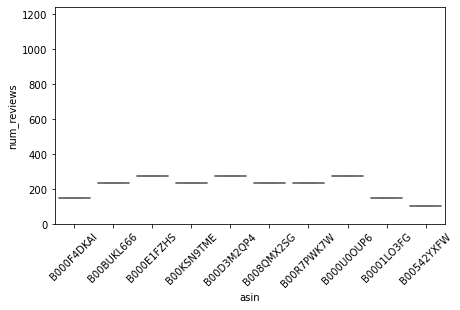

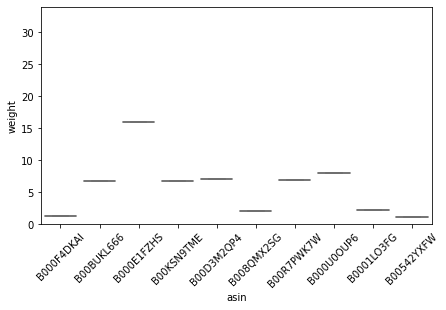

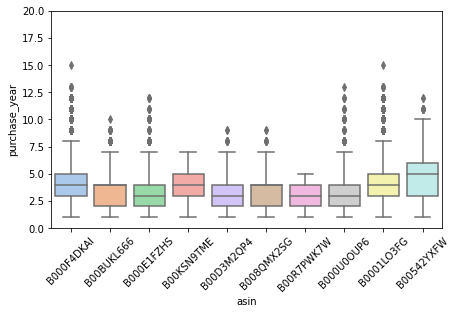

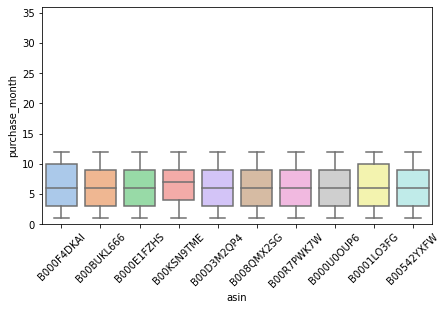

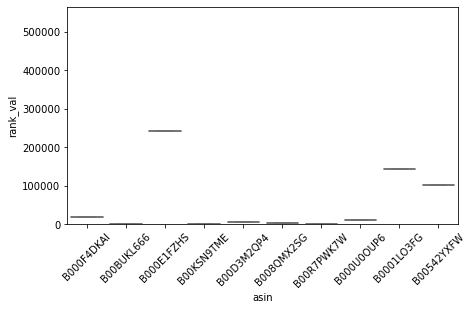

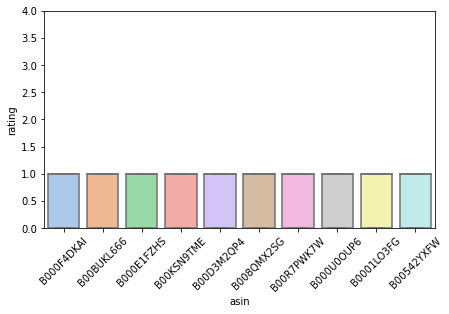

In [68]:
category_over_numeric_features(data, 'asin', 10, numeric_cols)

In [69]:
# Train and test data have 41320 unique products together.

In [70]:
print(get_stat_dif('asin', data, numeric_cols))

Найдены статистически значимые различия для колонки   asin   по   price
Найдены статистически значимые различия для колонки   asin   по   num_of_stars
Найдены статистически значимые различия для колонки   asin   по   num_reviews
Найдены статистически значимые различия для колонки   asin   по   weight
Найдены статистически значимые различия для колонки   asin   по   purchase_year
Найдены статистически значимые различия для колонки   asin   по   purchase_month
Найдены статистически значимые различия для колонки   asin   по   rank_val
Найдены статистически значимые различия для колонки   asin   по   rating
None


In [71]:
# 'asin' has statistically significant differences with all numerical features.

# 'userid'

842      558
355      412
17987    408
2024     373
2809     357
        ... 
85049      3
90229      3
89857      2
60294      2
81716      2
Name: userid, Length: 127496, dtype: int64
               
842      0.000500
355      0.000370
17987    0.000366
2024     0.000335
2809     0.000320
           ...   
85049    0.000003
90229    0.000003
89857    0.000002
60294    0.000002
81716    0.000002
Name: userid, Length: 127496, dtype: float64
                 
Number of unique values   127496


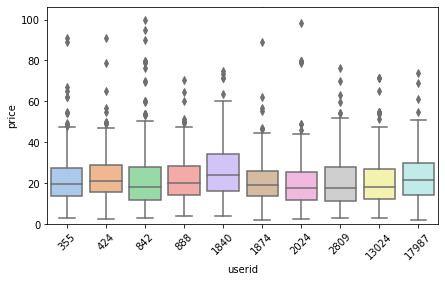

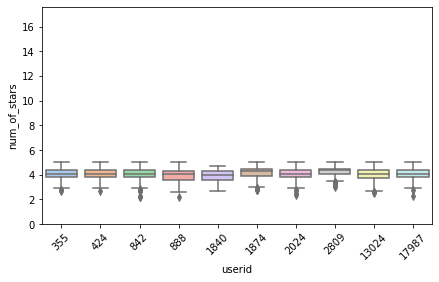

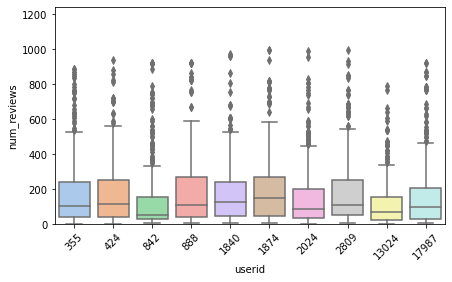

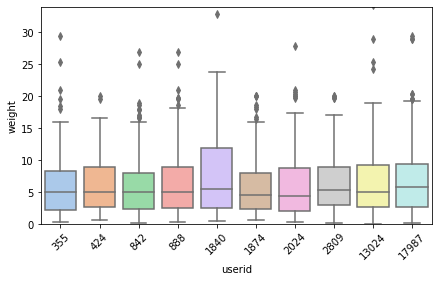

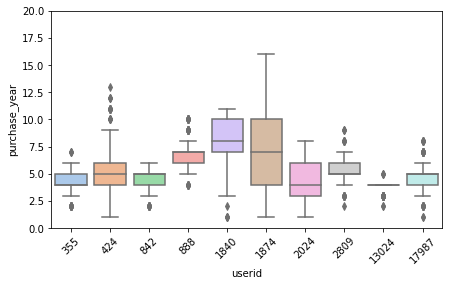

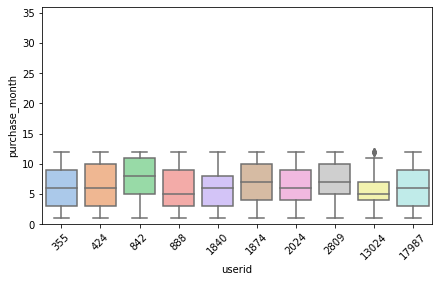

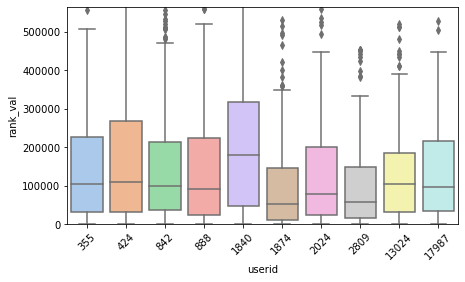

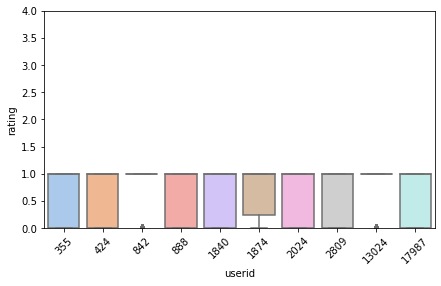

In [72]:
category_over_numeric_features(data, 'userid', 10, numeric_cols)

In [73]:
# Train and test data have 127496 unique customers together.

In [74]:
print(get_stat_dif('userid', data, numeric_cols))

Найдены статистически значимые различия для колонки   userid   по   price
Найдены статистически значимые различия для колонки   userid   по   num_of_stars
Найдены статистически значимые различия для колонки   userid   по   num_reviews
Найдены статистически значимые различия для колонки   userid   по   weight
Найдены статистически значимые различия для колонки   userid   по   purchase_year
Найдены статистически значимые различия для колонки   userid   по   purchase_month
Найдены статистически значимые различия для колонки   userid   по   rank_val
Найдены статистически значимые различия для колонки   userid   по   rating
None


In [75]:
# 'userid' has statistically significant differences with all numerical features.

# 'brand'

KIND                              30988
Bob's Red Mill                    17826
Planters                          14099
Twinings                          14064
Green Mountain Coffee Roasters     9015
                                  ...  
SEA2O                                 1
Mayers                                1
Novus Tea                             1
Appian Way                            1
Mallo Cup                             1
Name: brand, Length: 8869, dtype: int64
               
KIND                              2.779442e-02
Bob's Red Mill                    1.598888e-02
Planters                          1.264598e-02
Twinings                          1.261458e-02
Green Mountain Coffee Roasters    8.085927e-03
                                      ...     
SEA2O                             8.969414e-07
Mayers                            8.969414e-07
Novus Tea                         8.969414e-07
Appian Way                        8.969414e-07
Mallo Cup                         

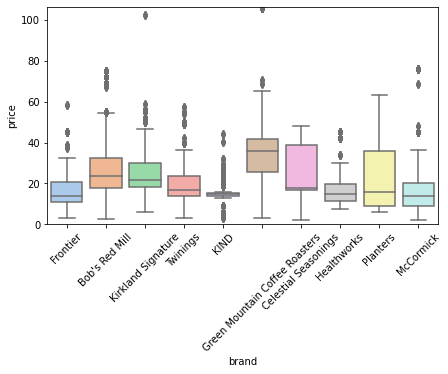

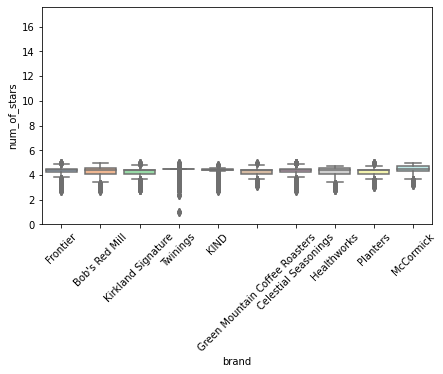

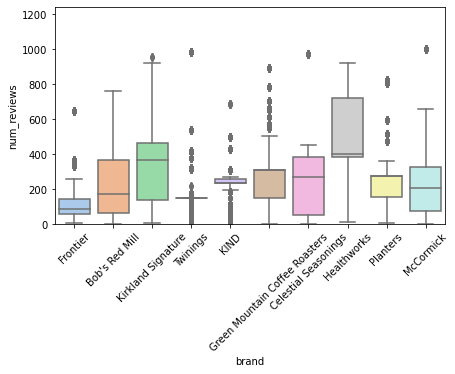

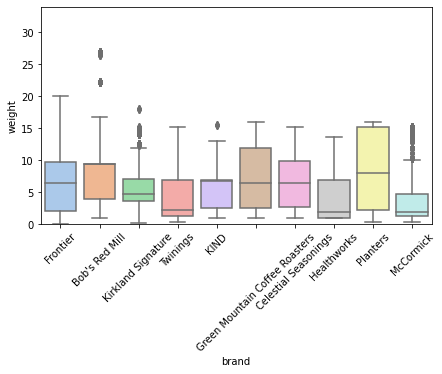

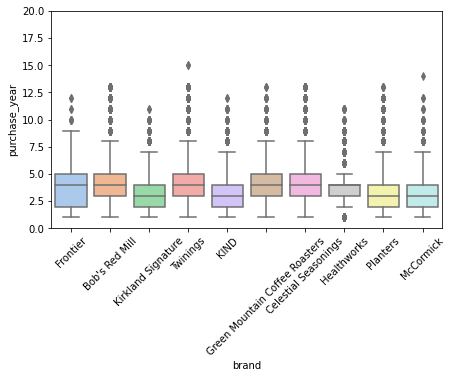

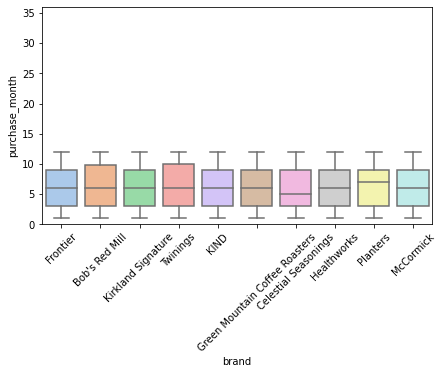

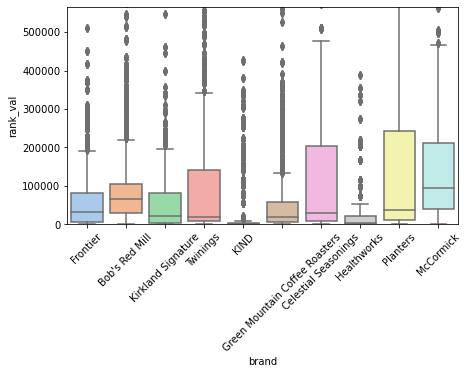

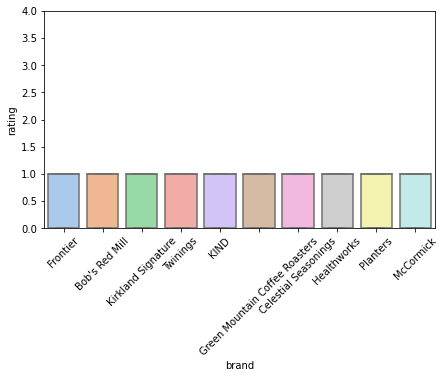

In [76]:
category_over_numeric_features(data, 'brand', 10, numeric_cols)

In [77]:
# Train and test data have 8869 unique brands together.

In [78]:
print(get_stat_dif('brand', data, numeric_cols))

Найдены статистически значимые различия для колонки   brand   по   price
Найдены статистически значимые различия для колонки   brand   по   num_of_stars
Найдены статистически значимые различия для колонки   brand   по   num_reviews
Найдены статистически значимые различия для колонки   brand   по   weight
Найдены статистически значимые различия для колонки   brand   по   purchase_year
Найдены статистически значимые различия для колонки   brand   по   purchase_month
Найдены статистически значимые различия для колонки   brand   по   rank_val
Найдены статистически значимые различия для колонки   brand   по   rating
None


In [79]:
# 'brand' has statistically significant differences with all numerical features.

# 'cat1'

 Beverages                             295332
 Cooking & Baking                      216190
 Snack Foods                           140261
 Candy & Chocolate                     118619
 Herbs                                  72078
 Breakfast Foods                        52629
 Canned                                 40558
 Produce                                25991
 Soups                                  22184
 Sauces                                 20427
 Jams                                   20283
 Dairy                                  14901
 Dried Beans                            14009
 Pasta & Noodles                        11533
 Condiments & Salad Dressings           11026
 Food & Beverage Gifts                   9974
 Breads & Bakery                         8972
 Meat & Seafood                          5944
 Frozen                                  4244
 Olives                                  3628
 Fresh Flowers & Live Indoor Plants      2998
 Prepared Foods                   

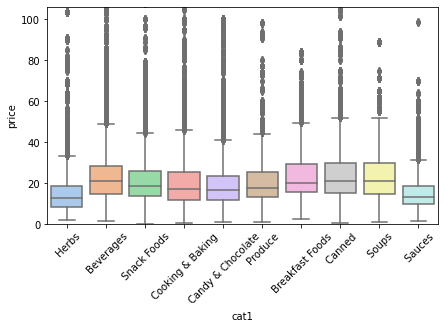

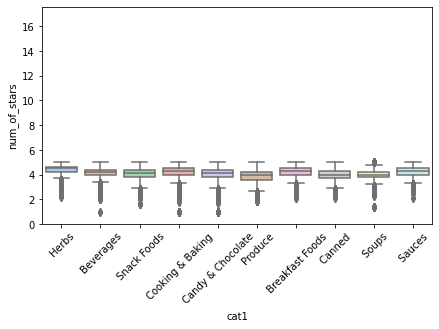

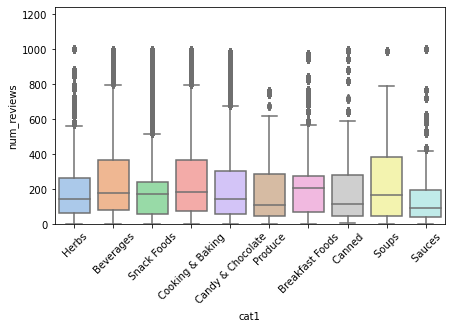

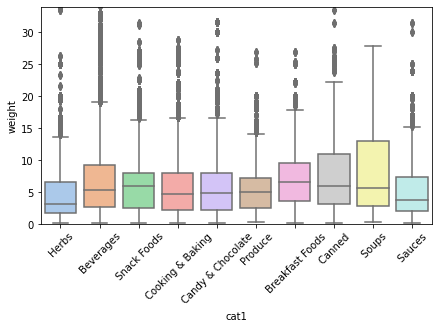

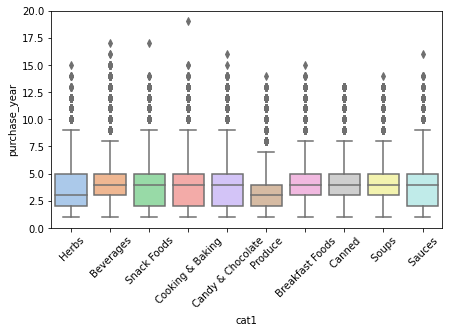

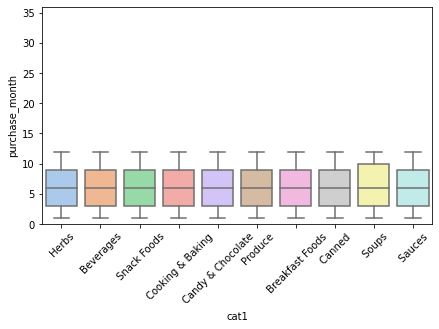

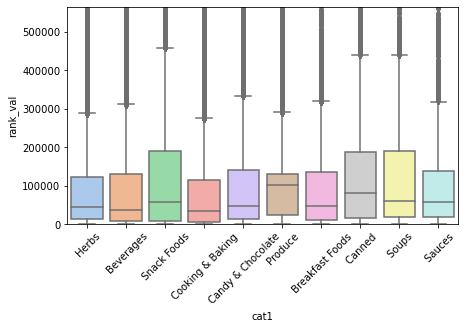

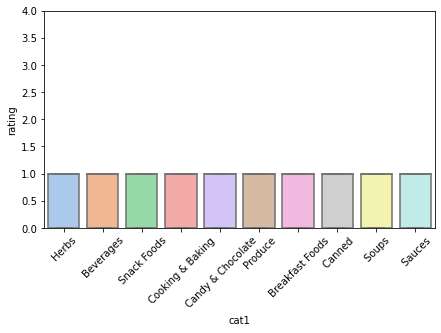

In [80]:
category_over_numeric_features(data, 'cat1', 10, numeric_cols)

In [81]:
print(get_stat_dif('cat1', data, numeric_cols))

Найдены статистически значимые различия для колонки   cat1   по   price
Найдены статистически значимые различия для колонки   cat1   по   num_of_stars
Найдены статистически значимые различия для колонки   cat1   по   num_reviews
Найдены статистически значимые различия для колонки   cat1   по   weight
Найдены статистически значимые различия для колонки   cat1   по   purchase_year
Найдены статистически значимые различия для колонки   cat1   по   purchase_month
Найдены статистически значимые различия для колонки   cat1   по   rank_val
Найдены статистически значимые различия для колонки   cat1   по   rating
None


In [82]:
# 'cat1' has statistically significant differences with all numerical features.

# 'rating'

1.0    703165
0.0    411735
Name: rating, dtype: int64
               
1.0    0.630698
0.0    0.369302
Name: rating, dtype: float64
                 
Number of unique values   2


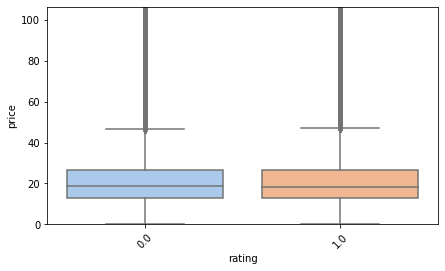

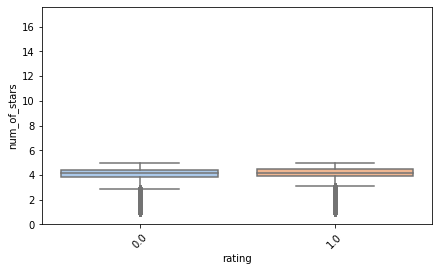

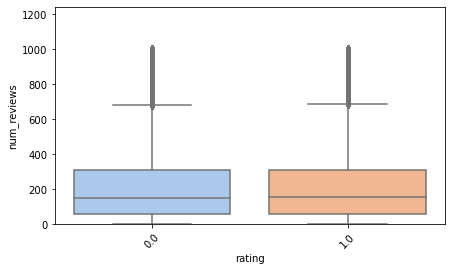

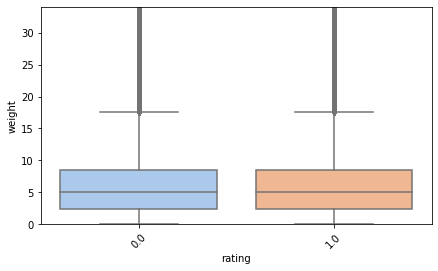

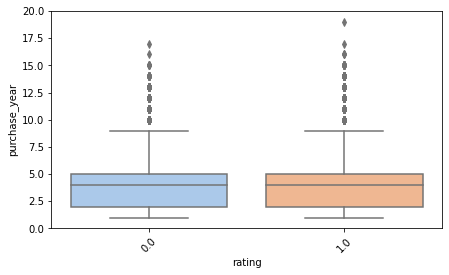

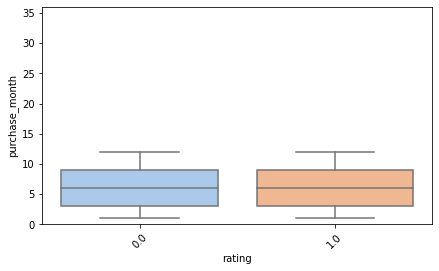

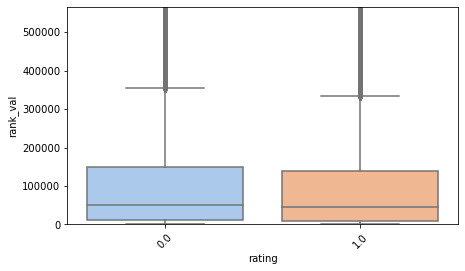

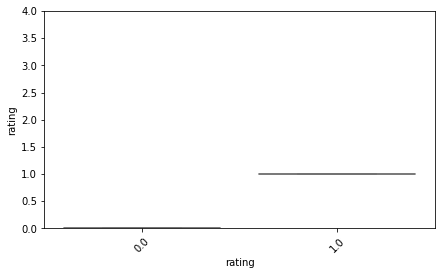

In [83]:
# Target variable 'rating' can be categorical feature. I can easily check with what numerical
# features it has statistical significant difference.

category_over_numeric_features(data, 'rating', 2, numeric_cols)

In [84]:
get_stat_dif('rating', data, numeric_cols)

Найдены статистически значимые различия для колонки   rating   по   num_of_stars
Найдены статистически значимые различия для колонки   rating   по   num_reviews
Найдены статистически значимые различия для колонки   rating   по   weight
Найдены статистически значимые различия для колонки   rating   по   purchase_year
Найдены статистически значимые различия для колонки   rating   по   purchase_month
Найдены статистически значимые различия для колонки   rating   по   rank_val
Найдены статистически значимые различия для колонки   rating   по   rating


In [85]:
# Target variable has statistically significant difference with all numerical features
# except price.

# Feature Engineering

In [86]:
# After filling in missed entries in number of stars feature, some entries got to many digits 
# after decimal point. Amazon products have only one digit after decimal point on amazon.com

data['round_stars'] = round(data['num_of_stars'], 1)


In [87]:
# The code below calculates new feature mean rank groupby category and number of stars

rank_table = data.groupby(['cat3', 'round_stars']).rank_val.mean()
data['mean_rank'] = data[['cat3', 'round_stars']].apply(
    lambda x: rank_table[x[0]][x[1]], axis=1)

In [88]:
# The code below calculates new feature mean number of stars groupby brand

star_table = data.groupby('brand').round_stars.mean()
data['mean_stars'] = data.brand.apply(lambda x: star_table[x])

In [89]:
# The code below calculates new feature mean number of stars groupby 'userid'

userid_star = data[data['sample'] == 1].groupby('userid').round_stars.mean()
data['user_stars'] = data['userid'].apply(
    lambda x: userid_star[x] if x in userid_star.index else 4)

In [90]:
# This feature shows if there is a known number of votes for feedback or not. The ratio of positive to
# negative ratings significantly changes between known and unknown number of votes.

data['known_votes'] = data['vote'].apply(lambda x: 1 if pd.notna(x) == True else 0)

In [91]:
rating_table = data[data['sample'] == 1].groupby('asin').rating.mean()
data['mean_rating'] = data.asin.apply(
    lambda x: rating_table[x] if x in rating_table.index else 0.5)

In [92]:
userid_table = data[data['sample'] == 1].groupby('userid').rating.mean()
data['userid_rating'] = data['userid'].apply(
    lambda x: userid_table[x] if x in userid_table.index else 0.5)

# Models

# Surprice

In [93]:
# dset = data[data['sample'] == 1][['userid', 'itemid', 'rating']]
# dset['rating'] = dset['rating'] + 1
# reader = Reader(rating_scale=(2, 1))

In [94]:
# from surprise import KNNBasic
# from surprise import NMF
# from surprise import SlopeOne

In [95]:
# s_dset = Dataset.load_from_df(dset[['userid', 'itemid', 'rating']], reader)

In [96]:
# kf = KFold(n_splits=5)
# #algo = SVD()
# knb = SlopeOne()

# for trainset, testset in kf.split(s_dset):
#     preds = []
#     test = []
#     # train and test algorithm.
#     knb.fit(trainset)
#     predictions = knb.test(testset)
    
#     for inter in predictions:
#         preds.append(inter.est)
#         test.append(inter.r_ui)
    
#     # Compute and print Root Mean Squared Error
#     print(accuracy.rmse(predictions, verbose=True))
#     print(sklearn.metrics.roc_auc_score(test,preds))

# lightgbm

In [97]:
# This problem can be solved by tree classification or tree regression algorithm like lightgbm

In [98]:


final_df = data[['userid', 'asin', 'verified', 'brand', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 
                 'round_stars', 'purchase_year', 'purchase_month', 'log_reviews', 'known_votes',
                 'log_rank_val', 'mean_rank',  'mean_stars', 'mean_rating', 'user_stars', 'userid_rating', 
                 'rating', 'sample']]



In [99]:
for clmn in ['verified', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'userid', 'asin', 'brand']:
    
    final_df[clmn]= final_df[clmn].astype('category').cat.codes
    


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


import re
final_df = final_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

del data
gc.collect()

In [100]:
X = final_df.query('sample == 1').drop(['sample'], axis=1)
y = X['rating']
X = X.drop(['rating'], axis=1)

X_sub = final_df.query('sample == 0').drop(['sample'], axis=1)
X_sub = X_sub.drop(['rating'], axis=1)


In [101]:
train_data, test_data, train_labels, test_labels = train_test_split(X, y, stratify=y, test_size = 0.2, random_state=42)

# Optuna для настройки параметров

def run(trial):
    scores = []
    
    #for fold in range(1):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    num_leaves = trial.suggest_int("num_leaves", 80, 150)
    max_depth = trial.suggest_int("max_depth", 11, 49)
    #bagging_freq = trial.suggest_int("bagging_freq", 10, 20)
    #max_bin = trial.suggest_int("max_bin", 2, 10)
    num_iterations = trial.suggest_int("num_iterations", 300, 650)
    
    
    lgb_train = lgb.Dataset(train_data, train_labels)
    
    param = {
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'learning_rate': learning_rate,
    'num_leaves': num_leaves,
    'max_depth': max_depth,
    'num_iterations': num_iterations}
    #'bagging_freq': bagging_freq,
    #'max_bin': max_bin}

    model = lgb.train(param, lgb_train, verbose_eval=1000)
    preds = model.predict(test_data)
    auc_score = sklearn.metrics.roc_auc_score(test_labels,preds)
    return auc_score

study = optuna.create_study(direction = 'maximize') 
study.optimize(run, n_trials = 50)

study.best_params

In [102]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train_data, train_labels)



param = {
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0 }

model_lgb = lgb.train(param, train_set = lgb_train, verbose_eval=1000)

In [103]:
predss = model_lgb.predict(test_data)
sklearn.metrics.roc_auc_score(test_labels,predss)



0.9229965037604955

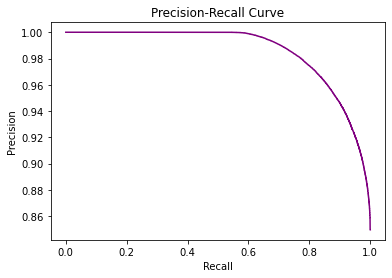

In [104]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(test_labels, predss)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [105]:
# The code below normalize model's prediction

predss_norm = (predss - predss.min())/(predss - predss.min()).max()



bin_preds = []

for pr in predss_norm:
    if pr > 0.5:
        bin_preds.append(1)
        
    else:
        bin_preds.append(0)

In [106]:
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


# F1 score is a good accuracy measure performance
f1_score = f1_score(test_labels, bin_preds)
print('f1 score  ',  f1_score)



# MSE is a mean squred error for results
print('Mean Squared Error  ',  mean_squared_error(test_labels, predss_norm))


f1 score   0.9371899970660821
Mean Squared Error   0.07976047004867025


In [107]:

# The code below loads submission file
submission = pd.read_csv('/kaggle/input/recommendationsv4/sample_submission.csv')

sub_predictions1 = model_lgb.predict(X_sub)


# LightFM Without Features (Collaborative Model)

In [108]:
# The prediction model below is purely collaborative model. It's good when all of your customers
# left enough number of ratings. This model is bad for new customers, it doesn't resolve the problem
# of cold start since you don't have ratings of products from new clients.

In [109]:
train_data, test_data = train_test_split(final_df[final_df['sample'] == 1],random_state=32, shuffle=True)

In [110]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['asin'])))

In [111]:
NUM_THREADS = 4 
NUM_COMPONENTS = 30 
NUM_EPOCHS = 20 

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [112]:
predics = model.predict(test_data.userid.values,
                      test_data.asin.values)

sklearn.metrics.roc_auc_score(test_data['rating'],predics)

0.7244635935813225

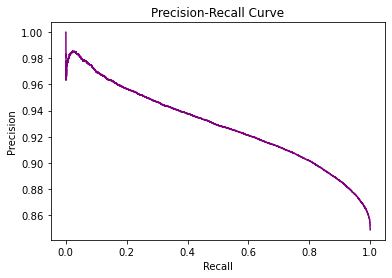

In [113]:
precision, recall, thresholds = precision_recall_curve(test_data['rating'], predics)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [114]:
predss_norm_2 = (predics - predics.min())/(predics - predics.min()).max()



bin_predss = []

for pr in predss_norm_2:
    if pr > 0.4:
        bin_predss.append(1)
        
    else:
        bin_predss.append(0)

In [115]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error


f1_score = metrics.f1_score(test_data['rating'], bin_predss)
print('f1 score  ',  f1_score)



print('Mean Squered error Error  ',  mean_squared_error(
    test_data['rating'], predss_norm_2))

f1 score   0.9187692050419114
Mean Squered error Error   0.21118529789788743


In [116]:
# For submission I will train the model on all known data

train_data_sub = final_df[final_df['sample'] == 1]
test_data_sub = final_df[final_df['sample'] == 0]



ratings_coo = sparse.coo_matrix((train_data_sub['rating'].astype(int),
                                 (train_data_sub['userid'],
                                  train_data_sub['asin'])))






NUM_THREADS = 4 
NUM_COMPONENTS = 30 
NUM_EPOCHS = 20 

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)





predzz = model.predict(test_data_sub.userid.values,
                      test_data_sub.asin.values)


sub_predictions2 = predzz

# LightFM With  Features (Hybrid Model)

In [117]:
# The recommendation system below is hybrid system because it considers
# ratings of customers, product features and customer features. This model
# might be good for new clients.

In [118]:
sub_data = data[['userid', 'asin', 'verified', 'brand', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 
                 'round_stars', 'purchase_year', 'purchase_month', 'log_reviews', 'known_votes',
                 'log_rank_val', 'mean_rank',  'mean_stars', 'mean_rating', 'user_stars', 'userid_rating', 
                 'rating', 'sample']]

In [119]:
sub_data['user_stars'] = round(sub_data['user_stars'], 2)
sub_data['user_stars'].nunique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


200

In [120]:
sub_data['mean_rating'] = round(sub_data['mean_rating'], 2)
sub_data['mean_rating'].nunique()

sub_data['mean_rating'] = round(sub_data['mean_rating'], 2)

sub_data['mean_stars'] = round(sub_data['mean_stars'], 2)
sub_data['mean_stars'].nunique()

sub_data['mean_rank'] = round(sub_data['mean_rank'] / 10000, 1)
sub_data['mean_rank'].nunique()

sub_data['log_rank_val'] = round(sub_data['log_rank_val'], 2)
sub_data['log_rank_val'].nunique()

sub_data['log_reviews'] = round(sub_data['log_reviews'], 1)
sub_data['log_reviews'].nunique()

sub_data['userid_rating'] = round(sub_data['userid_rating'],2)
sub_data['userid_rating'].nunique()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

96

In [121]:
train_data, test_data = train_test_split(sub_data[sub_data['sample'] == 1],random_state=32, shuffle=True)

In [122]:
# The code below creates LightFM-compliant dataset. The function below creates
# the list in which each element is in a format like 'feature_name:feature_value'

def light_fm_build_features(sub_features, id_key):
    sub_features.drop_duplicates(subset=[id_key], inplace=True)
    sub_features = sub_features.drop([id_key], axis=1)

    uf = []
    col = []
    unique_f1 = []

    for cln in sub_features.columns:
        col = col + [cln] * len(sub_features[cln].unique())

    for vals in sub_features.columns:
        unique_f1 = unique_f1 + list(sub_features[vals].unique())
    for x, y in zip(col, unique_f1):
        res = str(x) + ":" + str(y)
        uf.append(res)

    return uf

In [123]:
# lets create these lists 'feature_name:feature_value'

features_usr_train = train_data[['userid', 'verified', 'userid_rating']]
uf_table_train = light_fm_build_features(features_usr_train, 'userid')

features_usr_test = test_data[['userid', 'verified', 'userid_rating']]
uf_table_test = light_fm_build_features(features_usr_test, 'userid')


features_itm_train = train_data[['asin', 'brand', 'round_stars',
                                 'log_reviews', 'log_rank_val', 'mean_rank', 'mean_stars', 'mean_rating']]
it_table_train = light_fm_build_features(features_itm_train, 'asin')

features_itm_test = test_data[['asin', 'brand', 'round_stars',
                               'log_reviews', 'log_rank_val', 'mean_rank', 'mean_stars', 'mean_rating']]
it_table_test = light_fm_build_features(features_itm_test, 'asin')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [124]:
# The function below calls fit to supply userid, item id and user/item features dataset.fit

from lightfm.data import Dataset



def build_dataset(data, uf, uf_i):
    dataset1 = Dataset()
    dataset1.fit(
        data['userid'].unique(),  # all the users
        data['asin'].unique(),  # all the items



        user_features=uf_i,
        item_features=uf)

    return dataset1


dataset1_train = build_dataset(train_data, it_table_train, uf_table_train)
dataset1_test = build_dataset(test_data, it_table_test, uf_table_test)


# The code below builds interactions. 
#The input to the build_interactions method is an iterable of interactions where 
#each interaction is a tuple containing three elements:

#user
#item
#interaction weights or rating in my case

(interactions, weights) = dataset1_train.build_interactions(
    [(x[0], x[1], x[-1]) for x in train_data.values])

In [125]:
# interactions.todense()
# weights.todense()

In [126]:
# The function that takes the user features and converts them into the proper "feature:value" format
# Takes as input a list and prepends the columns names to respective values in the list.
# For example: if my_list = [1,1,0,'del'],resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']

def feature_colon_value(my_list, colon_list):
    """
    Takes as input a list and prepends the columns names to respective values in the list.
    For example: if my_list = [1,1,0,'del'],
    resultant output = ['f1:1', 'f2:1', 'f3:0', 'loc:del']

    """
    result = []
    ll = colon_list
    aa = my_list
    for x, y in zip(ll, aa):
        res = str(x) + "" + str(y)
        result.append(res)
    return result


# The function below generates user features in proper format for ALL users

def generates_features_in_proper_format(features, id):
    colon_list = []
    features = features.drop(id, axis=1)
    for cln in features.columns:
        cln = cln + ':'
        colon_list.append(cln)

    ad_list = [list(x) for x in features.values]
    features_list = []
    for item in ad_list:
        features_list.append(feature_colon_value(item, colon_list))

    return features_list

In [127]:
# The code below associates each element of the feature lists with the corresponding 
# user ids and product ids.

features_list_usr_train = generates_features_in_proper_format(
    features_usr_train, 'userid')
features_list_itm_train = generates_features_in_proper_format(
    features_itm_train, 'asin')

features_list_usr_test = generates_features_in_proper_format(
    features_usr_test, 'userid')
features_list_itm_test = generates_features_in_proper_format(
    features_itm_test, 'asin')



In [128]:
# The code below associates each element of the feature lists with the 
# corresponding user ids and product ids.

usr_tpl_train = list(zip(features_usr_train.userid, features_list_usr_train))
itm_tpl_train = list(zip(features_itm_train.asin, features_list_itm_train))

usr_tpl_test = list(zip(features_usr_test.userid, features_list_usr_test))
itm_tpl_test = list(zip(features_itm_test.asin, features_list_itm_test))



In [129]:
# Finally I got input for the build_user_features method

user_features_train = dataset1_train.build_user_features(
    usr_tpl_train, normalize=True)
itm_features_train = dataset1_train.build_item_features(
    itm_tpl_train, normalize=True)


user_features_test = dataset1_test.build_user_features(
    usr_tpl_test, normalize=True)
itm_features_test = dataset1_test.build_item_features(
    itm_tpl_test, normalize=True)


In [130]:
#item_features.todense()
#item_featurez_test.todense()

In [131]:

# The code below gets different important keys, I will need them later

user_id_map_train, user_feature_map_train, item_id_map_train, item_feature_map_train = dataset1_train.mapping()

user_id_map_test, user_feature_map_test, item_id_map_test, item_feature_map_test = dataset1_test.mapping()



def run(trial):
    scores = []
    
    #for fold in range(1):
    LR = trial.suggest_float("learning_rate", 0.01, 0.08)
    NUM_COMPONENTS = trial.suggest_int("no_components", 50, 200)
    LEARNING_SCHEDULE = trial.suggest_categorical('LEARNING_SCHEDULE', ['adagrad','adadelta'])
    #n_estimators = trial.suggest_int("n_estimators", 280, 400)
    #min_child_weight = trial.suggest_int("min_child_weight", 1, 2)

    xtrain = train_data
    xvalid = test_data

    ytrain = train_labels
    yvalid = test_labels

    model = LightFM(
        learning_rate=LR,
        loss=LOSS_FUNCTION,
        no_components=NUM_COMPONENTS,
        learning_schedule = LEARNING_SCHEDULE,
        random_state = 42)
    
    model.fit(interactions,
          user_features= item_featurez,
          item_features = user_featurez,
          sample_weight= weights,
          epochs=10)

    
    
    user_ids = train_data.itemid.apply(lambda x: user_id_map[x])
    item_ids = train_data.userid.apply(lambda x: item_id_map[x])
    preds = model.predict(user_ids.values, item_ids.values, user_features=item_featurez, item_features=user_featurez)

    val = sklearn.metrics.roc_auc_score(train_data.rating,preds)
    return val

study = optuna.create_study(direction = 'maximize')
study.optimize(run, n_trials = 25)

In [132]:
# Time to build the LightFM hybrid model

LR = 0.5
NUM_THREADS = 12  
NUM_COMPONENTS = 100  
NUM_EPOCHS = 1  
LEARNING_SCHEDULE = 'adadelta'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model_w_features = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    rho=0.2,
    item_alpha=0.25,

    no_components=NUM_COMPONENTS,
    learning_schedule=LEARNING_SCHEDULE,
    random_state=RANDOM_STATE)



model_w_features.fit(interactions,
          user_features=user_features_train,
          item_features=itm_features_train,
          sample_weight=weights,
          epochs=2)

In [133]:

# item_ids = train_data.asin.apply(lambda x: item_id_map_train[x])
# user_ids = train_data.userid.apply(lambda x: user_id_map_train[x])
# preds = model.predict(user_ids.values, item_ids.values,
#                       user_features=user_features_train, item_features=itm_features_train)
# train_preds2 = preds
# sklearn.metrics.roc_auc_score(train_data.rating, preds)

In [134]:

item_ids = test_data.asin.apply(lambda x: item_id_map_test[x])
user_ids = test_data.userid.apply(lambda x: user_id_map_test[x])
predss = model_w_features.predict(user_ids.values, item_ids.values,
                       user_features=user_features_test, item_features=itm_features_test)

sklearn.metrics.roc_auc_score(test_data.rating, predss)


0.6923088745948714

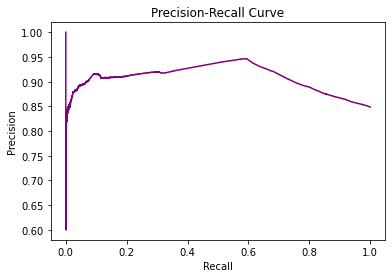

In [135]:
precision, recall, thresholds = precision_recall_curve(test_data['rating'], predss)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show()

In [136]:
predss_norm_3 = (predss - predss.min())/(predss - predss.min()).max()



bin_predss = []

for pr in predss_norm_3:
    if pr > 0.00005:
        bin_predss.append(1)
        
    else:
        bin_predss.append(0)

In [137]:
f1_score = metrics.f1_score(test_data['rating'], bin_predss)
print('f1 score  ',  f1_score)


print('Mean Squered error Error  ',  mean_squared_error(
    test_data['rating'], bin_predss))

f1 score   0.9178960235702196
Mean Squered error Error   0.1516836040418078


In [138]:
# I will train the model on all available data for the submission.


train_data = sub_data[sub_data['sample'] == 1]
test_data = sub_data[sub_data['sample'] == 0]


features_usr_train = train_data[['userid', 'verified', 'userid_rating']]
uf_table_train = light_fm_build_features(features_usr_train, 'userid')

features_usr_test = test_data[['userid', 'verified', 'userid_rating']]
uf_table_test = light_fm_build_features(features_usr_test, 'userid')


features_itm_train = train_data[['asin', 'brand', 'round_stars',
                                 'log_reviews', 'log_rank_val', 'mean_rank', 'mean_stars', 'mean_rating']]
it_table_train = light_fm_build_features(features_itm_train, 'asin')

features_itm_test = test_data[['asin', 'brand', 'round_stars',
                               'log_reviews', 'log_rank_val', 'mean_rank', 'mean_stars', 'mean_rating']]
it_table_test = light_fm_build_features(features_itm_test, 'asin')


dataset1_train = build_dataset(train_data, it_table_train, uf_table_train)
dataset1_test = build_dataset(test_data, it_table_test, uf_table_test)


(interactions, weights) = dataset1_train.build_interactions(
    [(x[0], x[1], x[-1]) for x in train_data.values])


features_list_usr_train = generates_features_in_proper_format(
    features_usr_train, 'userid')
features_list_itm_train = generates_features_in_proper_format(
    features_itm_train, 'asin')

features_list_usr_test = generates_features_in_proper_format(
    features_usr_test, 'userid')
features_list_itm_test = generates_features_in_proper_format(
    features_itm_test, 'asin')


usr_tpl_train = list(zip(features_usr_train.userid, features_list_usr_train))
itm_tpl_train = list(zip(features_itm_train.asin, features_list_itm_train))

usr_tpl_test = list(zip(features_usr_test.userid, features_list_usr_test))
itm_tpl_test = list(zip(features_itm_test.asin, features_list_itm_test))


user_features_train = dataset1_train.build_user_features(
    usr_tpl_train, normalize=True)
itm_features_train = dataset1_train.build_item_features(
    itm_tpl_train, normalize=True)


user_features_test = dataset1_test.build_user_features(
    usr_tpl_test, normalize=True)
itm_features_test = dataset1_test.build_item_features(
    itm_tpl_test, normalize=True)


user_id_map_train, user_feature_map_train, item_id_map_train, item_feature_map_train = dataset1_train.mapping()
user_id_map_test, user_feature_map_test, item_id_map_test, item_feature_map_test = dataset1_test.mapping()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [139]:
LR = 0.5
NUM_THREADS = 12 
NUM_COMPONENTS = 100 
NUM_EPOCHS = 1 
LEARNING_SCHEDULE = 'adadelta'
LOSS_FUNCTION = 'logistic'
RANDOM_STATE = 20

model_w_features = LightFM(
    learning_rate=LR,
    loss=LOSS_FUNCTION,
    rho=0.2,
    item_alpha = 0.25,
    
    no_components=NUM_COMPONENTS,
    learning_schedule = LEARNING_SCHEDULE,
    random_state = RANDOM_STATE)




model_w_features.fit(interactions,
      user_features= user_features_train,
      item_features = itm_features_train,
      sample_weight= weights,
      epochs=2)

In [140]:
item_ids = test_data.asin.apply(lambda x: item_id_map_test[x])
user_ids = test_data.userid.apply(lambda x: user_id_map_test[x])
predss = model_w_features.predict(user_ids.values, item_ids.values,
                       user_features=user_features_test, item_features=itm_features_test)

In [141]:
sub_predictions3 = predss

# Weighted Hybrid Recommendation System

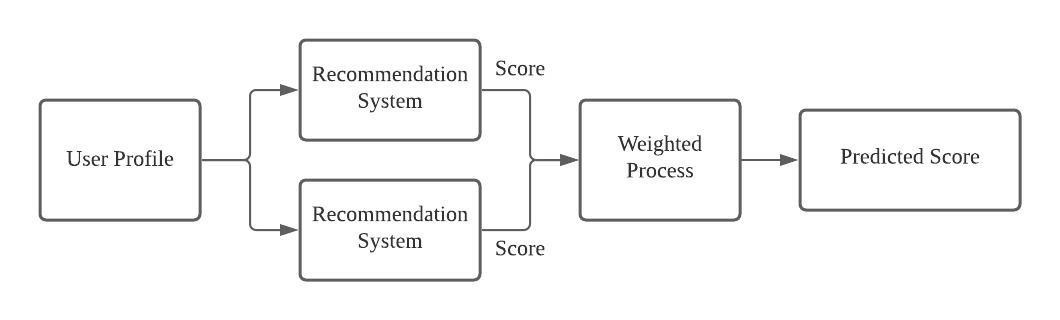

**The Weighted Model is a hybrid recommendation model. In the weighted recommendation system uses a few models that is able to well interpret the dataset. The weighted recommendation system will take the outputs from each of the models and combine the result in static weightings, which the weight does not change across the train and test set. For example, we can combine a content-based model and a item-item collaborative filtering model, and each takes a weight of 50% toward the final prediction. The benefit of using the weighted hybrid is that we integrate multiple models to support the dataset on the recommendation process in a linear way.**



In [142]:
# The code below builds table from the three recommendatiom models' prediction results



preds_df = pd.DataFrame(data=[sub_predictions1, sub_predictions2,
                              sub_predictions3], index=['reg', 'lightfm', 'ligthfm_feat']).T

preds_df

,reg,lightfm,ligthfm_feat
0,1.001660,2.160889,0.000059
1,1.001726,1.476859,0.000239
2,0.428069,0.373906,0.000273
3,0.362095,0.774440,0.000697
4,0.809071,2.308608,0.000041
...,...,...,...
285960,0.998906,2.497214,0.000016
285961,0.774861,-4.733819,0.000153
285962,0.439717,0.972978,0.000039
285963,0.938728,2.611759,0.000108


In [143]:
# The code below normalize prediction results

norm_stats = {}

for clm in preds_df.columns:
    
    norm_stats[clm] = list()
    norm_stats[clm].append(preds_df[clm].min())
    norm_stats[clm].append((preds_df[clm] - preds_df[clm].min()).max())
    
    
    preds_df[clm] = (preds_df[clm] - preds_df[clm].min()) / \
        (preds_df[clm] - preds_df[clm].min()).max()
    
    


preds_df

,reg,lightfm,ligthfm_feat
0,0.933196,0.531474,0.001585
1,0.933252,0.520205,0.006719
2,0.446928,0.502035,0.007693
3,0.390998,0.508633,0.019757
4,0.769927,0.533907,0.001085
...,...,...,...
285960,0.930861,0.537014,0.000376
285961,0.740925,0.417891,0.004281
285962,0.456803,0.511904,0.001014
285963,0.879845,0.538901,0.002984


In [144]:
submission['rating'] = 1.9 * preds_df['reg'] + \
    (0.1 * preds_df['ligthfm_feat']) + preds_df['lightfm'] * 3.2


minn = submission['rating'].min()
max_of_mins = (submission['rating'] - submission['rating'].min()).max()

In [145]:
print(minn)
print(max_of_mins)

0.8135305855807586
3.9211635877545414


# Submission

**I chose to submit the results of Weighted Hybrid Recommendation System from the above models
I built. I selected this model because it gives best results on submission data. Weighted Hybrid Recommendation System resolve the problem of cold start, because it includes models that consider product features and
customer feuters. When we have new customers we can't use purely collaborative system, because we don't have
rating they left before. To build better feature based recommendation system for new clients, we have to 
ask them some basic questions like(what is your location, what is your occupanion, age, sex, what you looking for
right now...)
I experimented with much more algorithms. They either gave bad results or it was not engough memory on kaggle,
the training data is very big. Some algorithms don't work with gpu, but without gpu it's too long.**

In [146]:
submission.to_csv('submission_log_sml4.csv', index=False)

In [147]:
norm_stats

{'reg': [-0.09911818227738539, 1.1795785416405307],
 'lightfm': [-30.100725173950195, 60.70220375061035],
 'ligthfm_feat': [2.8742533686454408e-06, 0.03513466733875248]}


**The code below builds application. This application is based on the Weighted Recommendation System.
The application can return specific probability for specific customer and specific product. Plus it can
return 10 products that specific customer probably would like with probabilities for specific customer
how probable this customer would like each product. 
The app asks to provide customer id, then it asks if you would like to get probability for specific
product or you want to get list of ten products. If you choose specific product then app asks you to
provide product id and finaly it asks you to specify if this purchase is going to be verified or not.
If you choose the list of 10 products then app asks you about purchase verification and it returns you
the list of 10 products with probabilites of customer's satisfaction.**


In [148]:
# def build_vector(table, userid, asin, verified):

#     table = table[['userid', 'asin', 'verified', 'brand', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5',
#                    'round_stars', 'purchase_year', 'purchase_month', 'log_reviews', 'known_votes',
#                    'log_rank_val', 'mean_rank',  'mean_stars', 'mean_rating', 'user_stars', 'userid_rating']]

#     user_stars = table[table['userid'] == userid]['user_stars'].iloc[0]
#     userid_rating = table[table['userid'] == userid]['userid_rating'].iloc[0]

#     if asin == '':
#         asins = data.asin.unique()
#         sub_asins = random.sample(list(asins), 1500)

#         itm_indexes = []

#         for asn in sub_asins:
#             itm_index = table[table['asin'] == asn].index[0]

#             itm_indexes.append(itm_index)

#         df = table.filter(items=itm_indexes, axis=0)

#         brand = df['brand']
#         asin = df['asin']

#         for clmn in ['verified', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'userid', 'asin', 'brand']:
#             df[clmn] = df[clmn].astype('category').cat.codes

#         df['userid'] = userid
#         df['verified'] = verified
#         df['userid_rating'] = userid_rating
#         df['user_stars'] = user_stars

#         return df, asin, brand

#     usr_ind = table[table['userid'] == userid].index[0]
#     itm_index = table[table['asin'] == asin].index[0]

#     for clmn in ['verified', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'userid', 'asin', 'brand']:
#         table[clmn] = table[clmn].astype('category').cat.codes

    

#     vector = table.loc[[itm_index]]

#     vector['userid'] = userid
#     vector['verified'] = verified
#     vector['userid_rating'] = userid_rating

#     return vector


# def lightgbm_prediction(features):
#     prediction = model_lgb.predict(features)

#     prediction = (prediction - norm_stats['reg'][0]) / norm_stats['reg'][1]

#     return prediction


# def light_fm_pred(userid_vals, productid_vals):

#     prediction = model.predict(userid_vals, productid_vals)
#     prediction = (
#         prediction - norm_stats['lightfm'][0]) / norm_stats['lightfm'][1]

#     return prediction


# def build_fm_with_features(user_features, item_features):
#     data = item_features
#     data['userid'] = user_features['userid']

#     item_features['mean_rating'] = round(item_features['mean_rating'], 2)

#     item_features['mean_stars'] = round(item_features['mean_stars'], 2)
#     item_features['mean_rank'] = round(item_features['mean_rank'] / 10000, 1)
#     item_features['log_rank_val'] = round(item_features['log_rank_val'], 2)
#     item_features['log_reviews'] = round(item_features['log_reviews'], 1)
#     user_features['userid_rating'] = round(user_features['userid_rating'], 2)
#     uf_table = light_fm_build_features(user_features, 'userid')
#     it_table = light_fm_build_features(item_features, 'asin')

#     dataset_lightfm = build_dataset(data, it_table, uf_table)

#     features_list_usr = generates_features_in_proper_format(
#         user_features, 'userid')
#     features_list_itm = generates_features_in_proper_format(
#         item_features, 'asin')

#     usr_tpl = list(zip(user_features.userid, features_list_usr))
#     itm_tpl = list(zip(item_features.asin, features_list_itm))

#     user_featurez = dataset_lightfm.build_user_features(
#         usr_tpl, normalize=True)
#     itm_featurez = dataset_lightfm.build_item_features(itm_tpl, normalize=True)

#     user_id_map, user_feature_map, item_id_map, item_feature_map = dataset_lightfm.mapping()

#     item_ids = data.asin.apply(lambda x: item_id_map[x])
#     user_ids = data.userid.apply(lambda x: user_id_map[x])
#     prediction = model_w_features.predict(user_ids.values, item_ids.values,
#                                           user_features=user_featurez, item_features=itm_featurez)

#     prediction = np.log(prediction)
#     prediction = (
#         prediction - norm_stats['log_prd'][0]) / norm_stats['log_prd'][1]

#     return prediction


# def weighted_prediction(table, userid, verified, asin=''):
#     if asin == '':
#         vector, asin, brand = build_vector(table, userid, asin, verified)

#     else:
#         # .index[0]#['brand']
#         brand = table[table['asin'] == asin].iloc[0]['brand']
#         vector = build_vector(table, userid, asin, verified)

#     pred_lgbm = lightgbm_prediction(vector)

#     pred_lightfm = light_fm_pred(
#         vector['userid'].values, vector['asin'].values)

#     user_features = vector[['userid', 'verified', 'userid_rating']]
#     item_features = vector[['asin', 'brand', 'round_stars',
#                             'log_reviews', 'log_rank_val', 'mean_rank', 'mean_stars', 'mean_rating']]

#     if verified == 1:
#         user_features['verified'] = True
#     else:
#         user_features['verified'] = False

#     item_features['brand'] = brand
#     item_features['asin'] = asin

#     preds_light_features = build_fm_with_features(user_features, item_features)

#     predictions = 1.9 * pred_lgbm + \
#         (0.1 * preds_light_features) + pred_lightfm * 3.2

#     predictions = (predictions - minn) / max_of_mins

#     return predictions